# import packges

In [3]:
library(DESeq2)
library(data.table)
library(dplyr)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(EnsDb.Hsapiens.v75)
library(clusterProfiler)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)
library(IRdisplay)
library(GGally)
library(ChIPpeakAnno)
library(universalmotif)
library(IRdisplay)
library(ggpubr)
library(DiffBind)
library(kableExtra)
library(tidyverse)
library(ggraph)
library(tidygraph)
library(readxl)
library(corrplot)
library(ggrepel)
library(msigdbr)
library(fgsea)
library(ggvenn)
library(ComplexHeatmap)
library(ggVennDiagram)
library(venneuler)
library(sva)
library(DT)
library(tools)
library(tidyverse)
library(maSigPro)
library(RSQLite)

library(edgeR)

txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

source('~/script/utils.r')
base_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/'
setwd(base_dir)

data_dir = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/'
PP = 'relapse'


In [ ]:
add_ann = function(dat, n = NULL){
    if(!is.data.table(dat)){dat = as.data.table(dat, keep.rownames = T)}
    if(is.null(n)){n = length(unlist(strsplit(unname(unlist(dat[1,1])), ':')))}
    dat[, class_id := unlist(strsplit(rn, ':'))[n], by = 1:nrow(dat) ]
    dat[, family_id := unlist(strsplit(rn, ':'))[n-1], by = 1:nrow(dat) ]
    dat[, gene_id := unlist(strsplit(rn, ':'))[n-2], by = 1:nrow(dat) ]
    if(n == 4) { dat[, tx_id := unlist(strsplit(rn, ':'))[n-3], by = 1:nrow(dat) ] } 
    dat
}


# design table

In [69]:
dsn = fread(paste0(data_dir, 'bam_list'))
dsn[, bam_ori_file := paste0(data_dir, bam_ori_file)]
dsn[, sample_name := sub('_rnaseq.sortedB.*', '', basename(bam_ori_file)) ]
dsn[, group := sub('.*_', '', sample_name)]
dsn = dsn[order(sample_name), ]
dsn[, sample_dir := paste0(base_dir, sample_name, '/') ]
head(dsn)

bam_ori_file                                                                                                                                                                       
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch1/mapping_results/AML_003_Dx_rnaseq/AML_003_Dx_rnaseq.sortedByName.bam  
2 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch1/mapping_results/AML_003_rel_rnaseq/AML_003_rel_rnaseq.sortedByName.bam
3 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch1/mapping_results/AML_015_Dx_rnaseq/AML_015_Dx_rnaseq.sortedByName.bam  
4 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch1/mapping_results/AML_015_rel_rnaseq/AML_015_rel_rnaseq.sortedByName.bam
5 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch1/mapping_results/AML_028_Dx_rnaseq/AML_028_Dx_rnaseq.sortedByName.bam  
6 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/./batch2/mapping_results/AML_028_rel_rnaseq/AML_028_rel_rnaseq.sortedByName.bam
  sample_name group
1 AML_003_Dx  Dx   
2 AML_003_rel rel  
3 AML_015_Dx  Dx   
4 AML_015_rel rel  
5 AML_028_Dx  Dx   
6 AML_028_rel rel  
  sample_dir                                                                                           
1 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/ 
2 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_rel/
3 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_015_Dx/ 
4 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_015_rel/
5 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_028_Dx/ 
6 /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_028_rel/

In [71]:
# two samples has repeated bam files, and one copy is broken
dsn = dsn[file.size(bam_ori_file) > 100000, ]

In [72]:
dim(dsn)

[1] 38  4

In [73]:
data_dir


[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/YuxuanLiu/Data_Yuxuan/27322744_PMID/"

In [74]:
#inv = dsn[, {dir.create(sample_dir)}, by = 1:nrow(dsn) ]

In [75]:
dsn[, sample_pre := paste0(sample_dir, sample_name) ]

In [175]:
dsn[, patient := sub('(AML_\\d+)_.*', '\\1', sample_name) ]


In [176]:
head(dsn[, .(sample_name, group, patient)])

sample_name group patient
1 AML_003_Dx  Dx    AML_003
2 AML_003_rel rel   AML_003
3 AML_015_Dx  Dx    AML_015
4 AML_015_rel rel   AML_015
5 AML_028_Dx  Dx    AML_028
6 AML_028_rel rel   AML_028

# bam to fastq

In [458]:
dim(dsn)

[1] 38 39

In [76]:
dsn[, fq_1 := paste0(sample_pre, '_r1.fastq')]
dsn[, fq_2 := paste0(sample_pre, '_r2.fastq')]

dsn[, sorted_bam_file := bam_ori_file ]
dsn[, bam2fq_jobname := paste0('bam2fq_', sample_name) ]
dsn[, bam2fq_oo := paste0(sample_pre, '_bam2fq.out')]
dsn[, bam2fq_er := paste0(sample_pre, '_bam2fq.err')]
dsn[, bam2fq_cmd := paste0('bsub -J ', bam2fq_jobname, ' -n 10 -o ', bam2fq_oo, ' -e ', bam2fq_er, ' -P beat -n 2 -R "rusage[mem=5GB]" ')]
dsn[, bam2fq_cmd := paste0(bam2fq_cmd, ' " singularity exec /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/images/depot.galaxyproject.org-singularity-picard-3.0.0--hdfd78af_1.img ')]
dsn[, bam2fq_cmd := paste0(bam2fq_cmd, ' picard SamToFastq -INPUT ', sorted_bam_file, ' --FASTQ ', fq_1, ' --SECOND_END_FASTQ ', fq_2, '"') ]
write(dsn[sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), bam2fq_cmd], file = 'run_relapse_bam2fq.sh')


# compress fastq

In [77]:
dsn[, fq_1_gz := paste0(sample_pre, '_r1.fastq.gz')]
dsn[, fq_2_gz := paste0(sample_pre, '_r2.fastq.gz')]


In [78]:
dsn[, sorted_bam_file := paste0(sample_pre, '_nameSorted.bam') ]
dsn[, fq1_gzip_jobname := paste0('fq1_gzip_', sample_name) ]
dsn[, fq1_gzip_oo := paste0(sample_pre, '_fq1_gzip.out')]
dsn[, fq1_gzip_er := paste0(sample_pre, '_fq1_gzip.err')]
dsn[, fq1_gzip_cmd := paste0('bsub -J ', fq1_gzip_jobname, ' -n 10 -o ', fq1_gzip_oo, ' -e ', fq1_gzip_er, ' -P beat -n 2 -R "rusage[mem=5GB]" ')]
dsn[, fq1_gzip_cmd := paste0(fq1_gzip_cmd, ' " gzip ', fq_1, ' "')]
write(dsn[sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), fq1_gzip_cmd], file = 'run_fq1_gzip.sh')
dsn[1, fq1_gzip_cmd]


[1] "bsub -J fq1_gzip_AML_003_Dx -n 10 -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_fq1_gzip.out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_fq1_gzip.err -P beat -n 2 -R \"rusage[mem=5GB]\"  \" gzip /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_r1.fastq \""

In [79]:
dsn[, sorted_bam_file := paste0(sample_pre, '_nameSorted.bam') ]
dsn[, fq2_gzip_jobname := paste0('fq2_gzip_', sample_name) ]
dsn[, fq2_gzip_oo := paste0(sample_pre, '_fq2_gzip.out')]
dsn[, fq2_gzip_er := paste0(sample_pre, '_fq2_gzip.err')]
dsn[, fq2_gzip_cmd := paste0('bsub -J ', fq2_gzip_jobname, ' -n 10 -o ', fq2_gzip_oo, ' -e ', fq2_gzip_er, ' -P beat -n 2 -R "rusage[mem=5GB]" ')]
dsn[, fq2_gzip_cmd := paste0(fq2_gzip_cmd, ' " gzip ', fq_2, ' "')]
write(dsn[sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), fq2_gzip_cmd], file = 'run_fq2_gzip.sh')
dsn[1, fq2_gzip_cmd]


[1] "bsub -J fq2_gzip_AML_003_Dx -n 10 -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_fq2_gzip.out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_fq2_gzip.err -P beat -n 2 -R \"rusage[mem=5GB]\"  \" gzip /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_r2.fastq \""

In [54]:
dsn[file.size(bam_file) < 1000, sample_name]

[1] "AML_049_Dx" "AML_049_Dx" "AML_051_Dx" "AML_051_Dx"

# align

In [86]:
# module load star/2.7.10a
REFERENCE_GENOME="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF"
REFERENCE_GENOME_FASTA='/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.fa'
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"


dsn[, star_jobname := paste0('star_', sample_name)]
dsn[, star_oo := paste0(sample_pre, 'star_out')]
dsn[, star_eo := paste0(sample_pre, 'star_err')]
dsn[, bam_prefix := paste0(sample_pre, '_')]
dsn[, bam_file := paste0(bam_prefix, 'Aligned.sortedByCoord.out.bam')]
#alignments/A549_0_1 Aligned.sortedByCoord.out.bam

dsn[, star_cmd := paste0('bsub -J ', star_jobname, ' -o ', star_oo, ' -e ', star_eo, ' -P ', PP, ' -n 30 -R "rusage[mem=5GB]" ')]
#dsn[, star_cmd := paste0(star_cmd, ' -w ', cutadapt_jobname)]
dsn[, star_cmd := paste0(star_cmd, ' -W 290')]
dsn[, star_cmd := paste0(star_cmd, ' " STAR --genomeDir ', REFERENCE_GENOME)] 
dsn[, star_cmd := paste0(star_cmd, ' --runThreadN 28 --outSAMtype BAM SortedByCoordinate --outFilterMultimapNmax 1000 --outSAMmultNmax 1 ')]
dsn[, star_cmd := paste0(star_cmd, ' --outFilterMismatchNmax 3 --outMultimapperOrder Random --winAnchorMultimapNmax 1000 --alignEndsType EndToEnd ')]
dsn[, star_cmd := paste0(star_cmd, ' --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn ', fq_1_gz, ' ', fq_2_gz, ' ')]
#dsn[, star_cmd := paste0(star_cmd, ' --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn ', fastq_r1_trimmed, ' ', fastq_r2_trimmed, ' ')]
dsn[, star_cmd := paste0(star_cmd, ' --readFilesCommand zcat --outFileNamePrefix ', bam_prefix, '"')]

write(dsn[sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), star_cmd], file = paste0(base_dir, 'run_relapse_star.sh'))

#STAR --genomeDir $REFERENCE_GENOME \
#                --runThreadN 28 --outSAMtype BAM SortedByCoordinate --outFilterMultimapNmax 1000 --outSAMmultNmax 1 \
#                --outFilterMismatchNmax 3 --outMultimapperOrder Random --winAnchorMultimapNmax 1000 --alignEndsType EndToEnd \
#                --alignIntronMax 1 --alignMatesGapMax 350 --quantMode TranscriptomeSAM --readFilesIn "$R1_FILE" "$R2_FILE" --readFilesCommand zcat \
#                --outFileNamePrefix "$OUTPUT_DIR/${SAMPLE_NAME}_"

In [87]:
dsn[file.size(dsn$bam_file) < 1000, sample_name]
file.exists(dsn$bam_file)
file.size(dsn$bam_file)

character(0)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

[1] 5237908410 4496644890 4694611301 4441173060 4511880379 4589524369
 [7] 5299396980 4785879690 2957764058 2897319397 2860954433 2903077322
[13] 2570953607 2844384075 2562180294 2704510570 2950255771 3319852007
[19] 1598524201 3511907401 4056427199 4113616082 2665433980 3072704678
[25] 4218177928 2453720581 4201156986 5119199011 3679718579 5802097251
[31] 2067726879 4075654011 3493570345 2084135058 4783780930 4125685584
[37] 4735012833 2798257875

In [88]:
dsn[1, sample_dir]

[1] "/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/"

# TEcount

In [92]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf"
bin_tecount = '/home/whu78/conda3/envs/te/bin/'

dsn[, tecount_jobname := paste0('tecount_', sample_name)]
dsn[, tecount_oo := paste0(sample_pre, '_tecount_out')]
dsn[, tecount_eo := paste0(sample_pre, '_tecount_err')]

dsn[, tecount_cmd := paste0('bsub -J ', tecount_jobname, ' -n 10 -o ', tecount_oo, ' -e ', tecount_eo, ' -P ', PP, ' -R "rusage[mem=5GB]" ')]
dsn[, tecount_cmd := paste0(tecount_cmd, ' -W 99:00')]
dsn[, tecount_cmd := paste0(tecount_cmd, ' " cd ', sample_dir, ' && ', bin_tecount, 'TEcount --sortByPos --format BAM --mode multi -b ', bam_file)] 
dsn[, tecount_cmd := paste0(tecount_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_GTF_FILE, ' --project tecount "')] 

write(dsn[!sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), tecount_cmd], file = paste0(base_dir, 'run_relapse_tecount.sh'))


In [90]:
dsn[, tecount_file := paste0(sample_dir, 'tecount.cntTable')]


In [91]:
dsn[, tecount_cmd][1]
file.exists(dsn[, tecount_file])

[1] "bsub -J tecount_AML_003_Dx -n 10 -o /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_tecount_out -e /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_tecount_err -P relapse -R \"rusage[mem=5GB]\"  -W 99:00 \" cd /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/ && /home/whu78/conda3/envs/te/bin/TEcount --sortByPos --format BAM --mode multi -b /research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/dataset/relapse/AML_003_Dx/AML_003_Dx_Aligned.sortedByCoord.out.bam --GTF /research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf --TE /research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf --project tecount \""

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE

# TElocal

In [95]:
GTF_FILE="/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/hs1.ncbiRefSeq.gtf"
TE_GTF_FILE = '/research/groups/jxugrp/home/common/Lab_Members/SyedAhmad/Projects_Main_Farhan/trimmed_copy_leukemia_samples/testig_new_T2T_GTF/T2T_CHM13_v2_rmsk_TE.gtf'
TE_loc_GTF_FILE = '/research/groups/jxugrp/home/common/Data_Public/RNA_seq/Blueprint_EGA_Data_EGAD00001000745_Transcriptional_Diversity_Human_Blood_progenitors_Chen_etal_Science_2014/T2T_CHM13_v2_rmsk_TE.gtf.locInd'

sif_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/images/telocal.sif'
bin_telocal = '/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/conda3/envs/snap/bin/'
exe_telocal = '/home/whu78/repos/TElocal/TElocal'
exe_telocal = '/home/whu78/conda3/envs/te/bin/TElocal'

dsn[, telocal_jobname := paste0('telocal_', sample_name)]
dsn[, telocal_oo := paste0(sample_pre, '_telocal_out')]
dsn[, telocal_eo := paste0(sample_pre, '_telocal_err')]

dsn[, telocal_cmd := paste0('bsub -J ', telocal_jobname, ' -n 10 -o ', telocal_oo, ' -e ', telocal_eo, ' -P ', PP, ' -R "rusage[mem=5GB]" ')]
dsn[, telocal_cmd := paste0(telocal_cmd, ' -W 99:00')]
dsn[, telocal_cmd := paste0(telocal_cmd, ' " cd ', sample_dir, ' && ', exe_telocal, ' --sortByPos -b ', bam_file)] 
dsn[, telocal_cmd := paste0(telocal_cmd, ' --GTF ', GTF_FILE, ' --TE ', TE_loc_GTF_FILE, ' --stranded reverse --project telocal "')] 

write(dsn[!sample_name %in% c('AML_051_Dx', 'AML_049_Dx'), telocal_cmd], file = paste0(base_dir, 'run_relapse_telocal.sh'))


In [94]:
dsn[, telocal_file := paste0(sample_dir, 'telocal.cntTable')]


In [98]:
dim(dsn)

[1] 38 38

In [100]:
file.size(dsn$telocal_file)

[1] 125056466 125063171 125059451 125076350 125066187 125068483 125085334
 [8] 125073318 125082855 125074596 125065359 125076325 125065152 125085730
[15] 125063521 125070374 125156834 125194328 125109290 125170621 125172030
[22] 125151034 125123196 125173787 125169382 125124044 125195242 125214137
[29] 125148507 125215360 125098592 125158391 125159979 125088728 125208102
[36] 125165003 125211329 125152803

# read tecount file

In [102]:
count_list = lapply(1:nrow(dsn), function(ii){
    fname = dsn[ii, tecount_file]
    tmp = fread(fname)
    #sname = dsn[ii, sample_name]
    setnames(tmp, 1, 'gene') 
    setnames(tmp, 2, 'value')
    tmp
})
names(count_list) = dsn[, sample_name]


In [104]:
count_dt = rbindlist(count_list, idcol = T)
count_dt = dcast(formula = gene ~ .id, value.var = 'value', count_dt) 
count_df = setDF(count_dt[, 2:ncol(count_dt)], rownames = count_dt$gene)
head(count_df)


AML_003_Dx AML_003_rel AML_015_Dx
(CATTC)n:Satellite:Satellite           0          0          0        
(GAATG)n:Satellite:Satellite           7          0          2        
7SLRNA:srpRNA:srpRNA                   0          0          1        
A-rich:Low_complexity:Low_complexity   0          0          0        
A1BG                                 477        567         94        
A1BG-AS1                             142        144         38        
                                     AML_015_rel AML_028_Dx AML_028_rel
(CATTC)n:Satellite:Satellite           0           3          0        
(GAATG)n:Satellite:Satellite           0           7          0        
7SLRNA:srpRNA:srpRNA                   0           1          1        
A-rich:Low_complexity:Low_complexity   1           0          0        
A1BG                                 154         627        625        
A1BG-AS1                             126         191         76        
                                     AML_032_Dx AML_032_rel AML_049_Dx
(CATTC)n:Satellite:Satellite           0          3           1       
(GAATG)n:Satellite:Satellite           1          2           6       
7SLRNA:srpRNA:srpRNA                   0          1           2       
A-rich:Low_complexity:Low_complexity   0          1           0       
A1BG                                 194        638         257       
A1BG-AS1                              42        116         101       
                                     AML_049_rel ⋯ AML_124_Dx AML_124_rel
(CATTC)n:Satellite:Satellite           1         ⋯   7          5        
(GAATG)n:Satellite:Satellite           4         ⋯  33         24        
7SLRNA:srpRNA:srpRNA                   0         ⋯   5          4        
A-rich:Low_complexity:Low_complexity   0         ⋯   1          0        
A1BG                                 638         ⋯ 102        167        
A1BG-AS1                             131         ⋯ 116        199        
                                     AML_125_Dx AML_125_rel AML_128_Dx
(CATTC)n:Satellite:Satellite          0          0            0       
(GAATG)n:Satellite:Satellite         13         23           11       
7SLRNA:srpRNA:srpRNA                  6          3           12       
A-rich:Low_complexity:Low_complexity  0          1            1       
A1BG                                 14         15          173       
A1BG-AS1                              9         21          264       
                                     AML_128_rel AML_133_Dx AML_133_rel
(CATTC)n:Satellite:Satellite           0           6          4        
(GAATG)n:Satellite:Satellite           2          44         11        
7SLRNA:srpRNA:srpRNA                   8          10          0        
A-rich:Low_complexity:Low_complexity   0           1          1        
A1BG                                 108         111        444        
A1BG-AS1                             108         236        430        
                                     AML_139_Dx AML_139_rel
(CATTC)n:Satellite:Satellite           0          1        
(GAATG)n:Satellite:Satellite          41         19        
7SLRNA:srpRNA:srpRNA                  10          1        
A-rich:Low_complexity:Low_complexity   0          1        
A1BG                                 214        163        
A1BG-AS1                             295        221

# cpm tecount

In [105]:
coding_genes = read.table('/research_jude/rgs01_jude/groups/jxugrp/home/common/Lab_Members/WenhuoHu/collab_Farhan/coding_gene_list', header = F)$V1
count_df_coding = count_df[rownames(count_df) %in% coding_genes, ] 
count_df_te     = count_df[!(rownames(count_df) %in% coding_genes), ] 


In [108]:
dge <- DGEList(count_df_coding)
dge <- calcNormFactors(dge)
logcpm_replase_coding = cpm(dge, normalized.lib.sizes = T, log = T)


In [109]:
dge <- DGEList(count_df_te)
dge <- calcNormFactors(dge)
logcpm_replase_te = cpm(dge, normalized.lib.sizes = T, log = T)


# DEG Tecount


In [6]:
library(BiocParallel)
register(MulticoreParam(20))


In [200]:
treatment = factor(dsn$group)
treatment = relevel(treatment, ref = 'Dx')
subject = factor(dsn$patient)
design <- model.matrix(~ subject + treatment)

dge = DGEList(counts=count_df_coding[, dsn$sample_name])
dge = estimateDisp(dge, design)
keep = filterByExpr(dge)
dge = dge[keep, , keep.lib.sizes=FALSE]
fit <- glmQLFit(dge, design)
qlf <- glmQLFTest(fit)
deg_relapse_coding = topTags(qlf, n = nrow(dge))
deg_relapse_coding = as.data.table(deg_relapse_coding$table, keep.rownames = T)
dim(deg_relapse_coding)
head(deg_relapse_coding)


[1] 29144     6

rn      logFC      logCPM    F        PValue       FDR        
1 CD109    2.9156704  4.320978 63.46877 4.638854e-08 0.001351948
2 TRANK1   1.1375338  6.218879 44.81276 7.938619e-07 0.011568156
3 ZC3H12C  1.4678662  4.872525 40.16483 1.826207e-06 0.012616606
4 SRGN    -1.5009311 10.358208 38.20487 2.645054e-06 0.012616606
5 CLSTN3   0.8913563  6.167080 37.66665 2.934600e-06 0.012616606
6 HTR7    -2.4501565  2.874356 37.33032 3.132935e-06 0.012616606

In [197]:
treatment = factor(dsn$group)
treatment = relevel(treatment, ref = 'Dx')
subject = factor(dsn$patient)
design <- model.matrix(~ subject + treatment)

dge = DGEList(counts=count_df_te[, dsn$sample_name])
dge = estimateDisp(dge, design)
fit <- glmQLFit(dge, design)
qlf <- glmQLFTest(fit)
deg_relapse_te = topTags(qlf, n = nrow(dge))
deg_relapse_te = as.data.table(deg_relapse_te$table, keep.rownames = T)
dim(deg_relapse_te)
head(deg_relapse_te)


[1] 1310    6

rn                      logFC     logCPM   F        PValue       FDR      
1 CER:Satellite:Satellite 0.7436741 6.322309 27.17335 2.625809e-05 0.0163458
2 LTR14C:ERVK:LTR         0.6877570 3.485161 26.37039 3.185543e-05 0.0163458
3 MER67B:ERV1:LTR         0.6273217 7.369102 25.71026 3.743312e-05 0.0163458
4 L1P2:L1:LINE            0.3616370 9.530011 22.85470 7.733100e-05 0.0253259
5 L1PBb:L1:LINE           0.6512038 6.228140 20.82366 1.334753e-04 0.0346588
6 L1PA12:L1:LINE          0.6744068 9.470657 20.19883 1.587426e-04 0.0346588

In [ ]:
deg_relapse_te = add_ann(deg_relapse_te)

# TEcount heatmap

In [391]:
dsn_row = deg_relapse_te[FDR < 0.1, ]
table(dsn_row$class_id)



      DNA      LINE       LTR Satellite   Unknown 
        5        12        17         1         1 

In [9]:
deg_relapse_te = as.data.table(deg_relapse_te)

In [11]:
head(deg_relapse_te)

rn                      logFC     logCPM   F        PValue       FDR      
1 CER:Satellite:Satellite 0.7436741 6.322309 27.17335 2.625809e-05 0.0163458
2 LTR14C:ERVK:LTR         0.6877570 3.485161 26.37039 3.185543e-05 0.0163458
3 MER67B:ERV1:LTR         0.6273217 7.369102 25.71026 3.743312e-05 0.0163458
4 L1P2:L1:LINE            0.3616370 9.530011 22.85470 7.733100e-05 0.0253259
5 L1PBb:L1:LINE           0.6512038 6.228140 20.82366 1.334753e-04 0.0346588
6 L1PA12:L1:LINE          0.6744068 9.470657 20.19883 1.587426e-04 0.0346588
  class_id  family_id gene_id
1 Satellite Satellite CER    
2 LTR       ERVK      LTR14C 
3 LTR       ERV1      MER67B 
4 LINE      L1        L1P2   
5 LINE      L1        L1PBb  
6 LINE      L1        L1PA12

In [12]:
te_sel = c(deg_relapse_te[grepl('herv-fc', gene_id, ignore.case = T) & FDR < 0.1, rn],
           deg_relapse_te[grepl('LTR12',  gene_id, ignore.case = T) & FDR < 0.1, rn],
           deg_relapse_te[grepl('herv9n', gene_id, ignore.case = T) & FDR < 0.1, rn])
te_sel

character(0)

In [ ]:
# significant TEs
options(repr.plot.width = 10, repr.plot.height = 2.5, repr.plot.res = 300)


plotdat = logcpm_te[te_sel, rownames(dsn_sel)]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 2] = 2
plotdat[plotdat < -2] = -2

column_ha = HeatmapAnnotation(df = dsn_sel)
#column_ra = rowAnnotation(df = row_sel[, .(.id)]) 
Heatmap(plotdat, name = "mat", show_column_names = F, show_row_names = T, show_column_dend = F, cluster_columns  = F, 
        cluster_rows = F, # row_split = row_sel$.id, 
        show_row_dend = F, top_annotation = column_ha, #left_annotation = column_ra, 
        column_split = factor(dsn_sel$cell_type, levels = cell_types))  

Warning message:
"The input is a data frame-like object, convert it to a matrix."


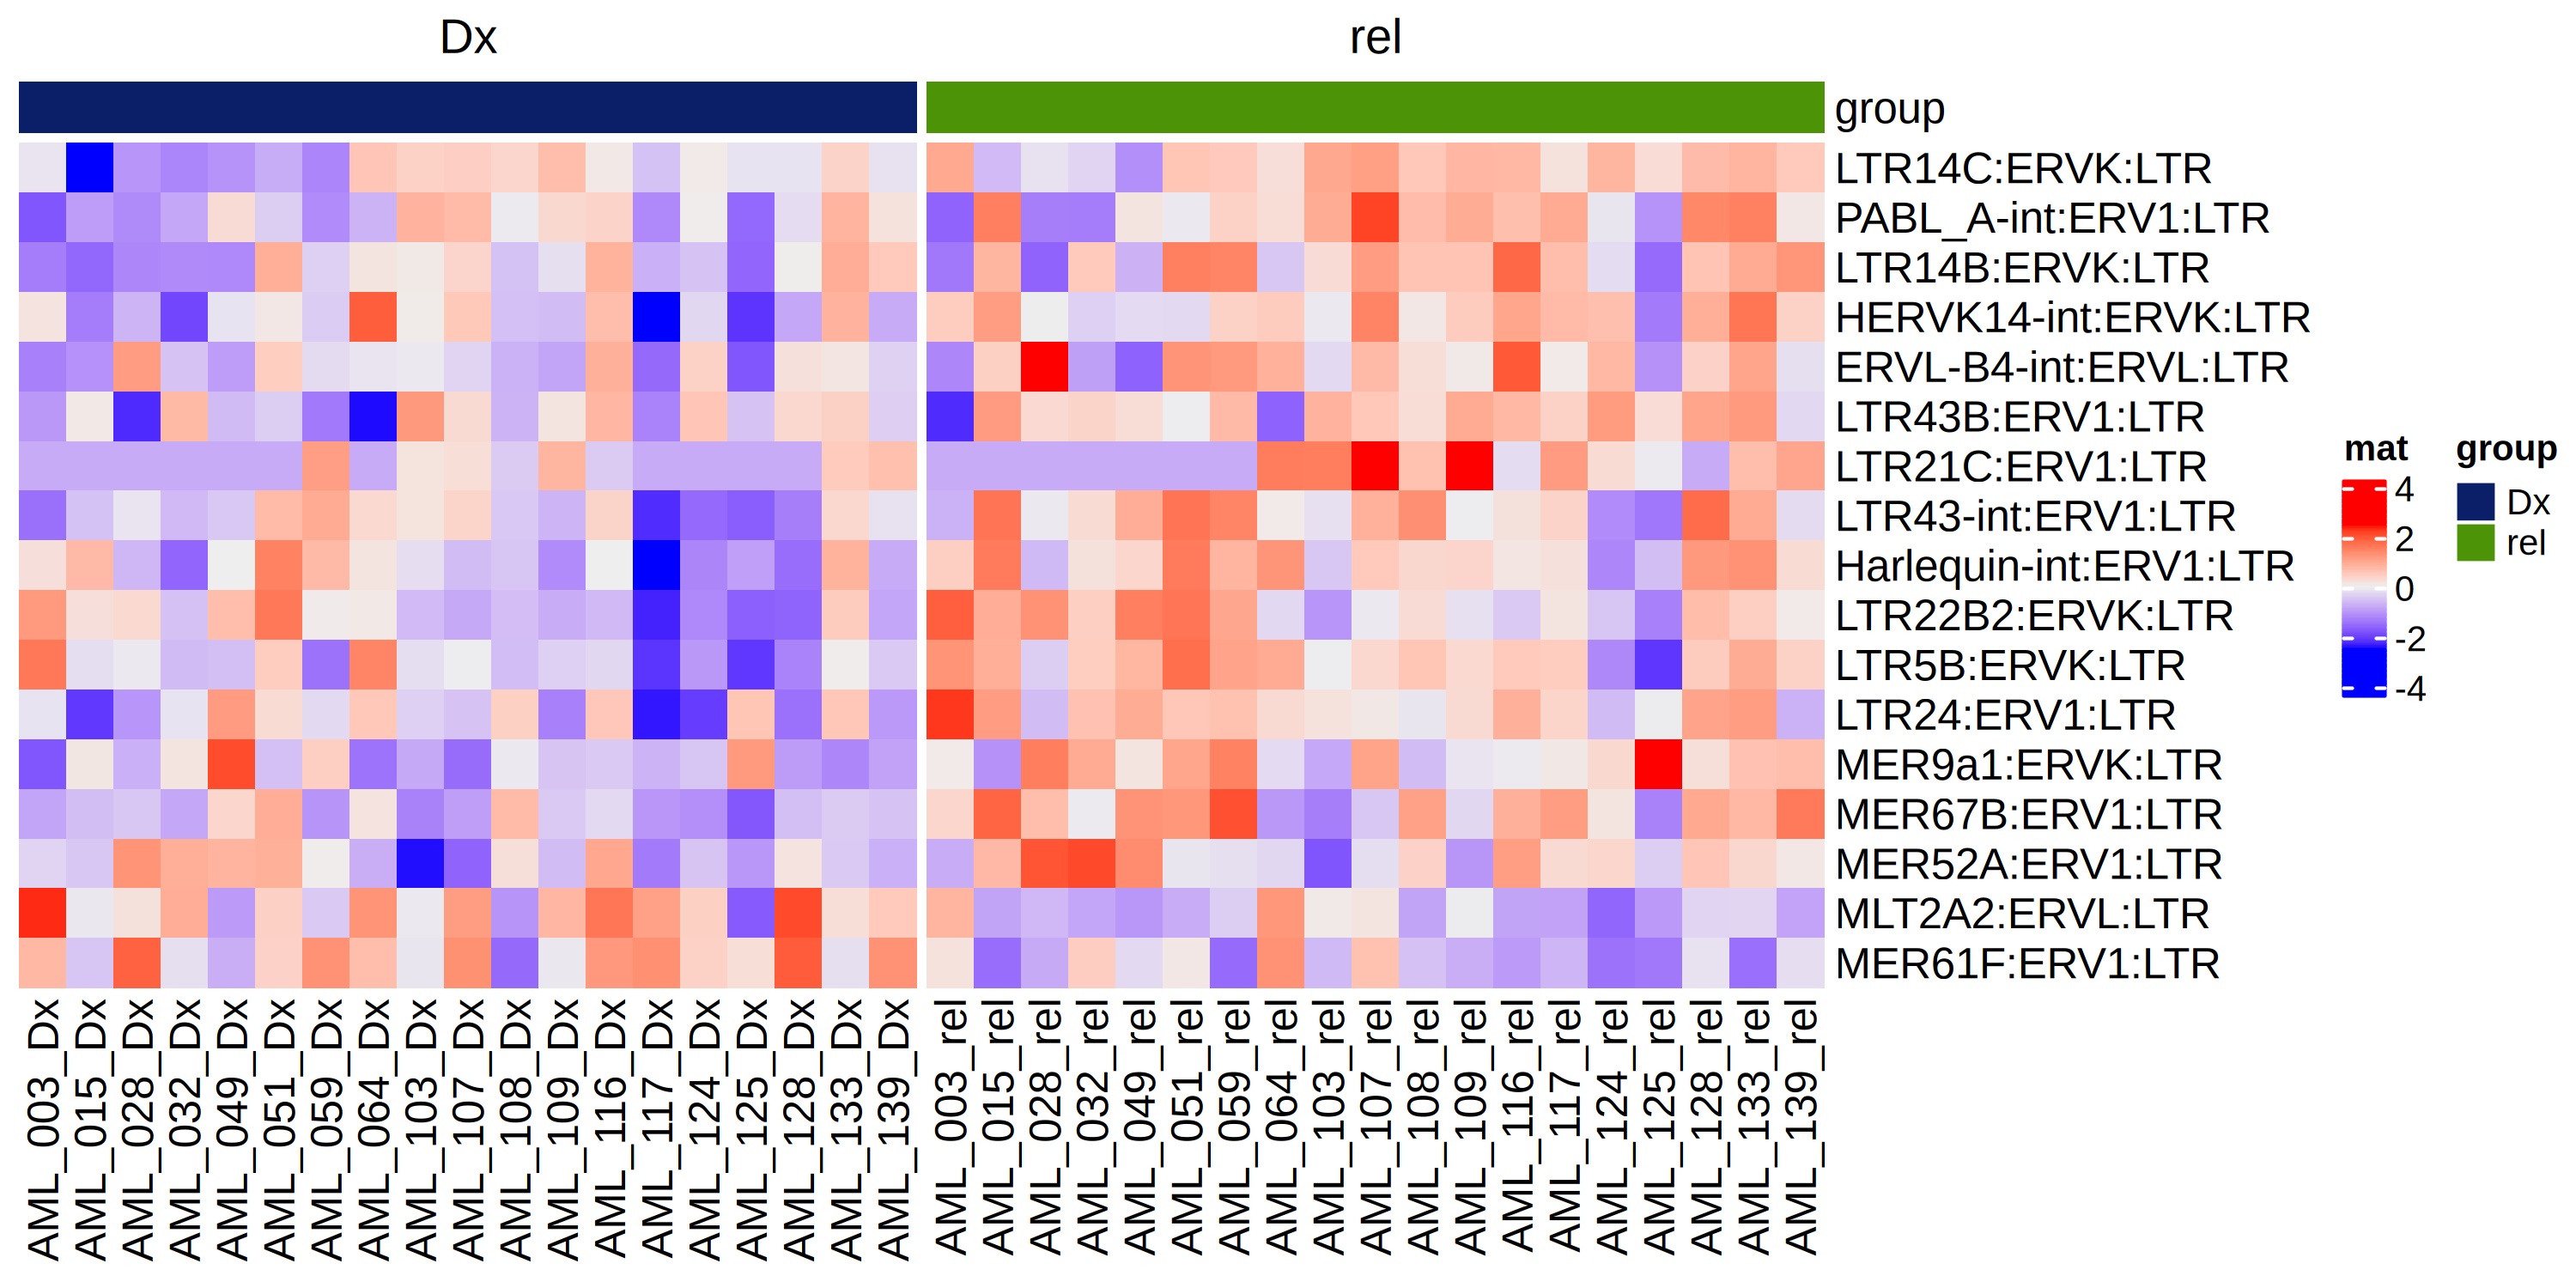

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

dsn_row = deg_relapse_te[FDR < 0.1 & class_id %in% c('LTR'), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sort = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sort$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 3] = 3
plotdat[plotdat < -3] = -3

column_ha = HeatmapAnnotation(df = dsn_sort[, 'group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, cluster_rows = T,  
        show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sort$group, levels = c('Dx', 'rel')))


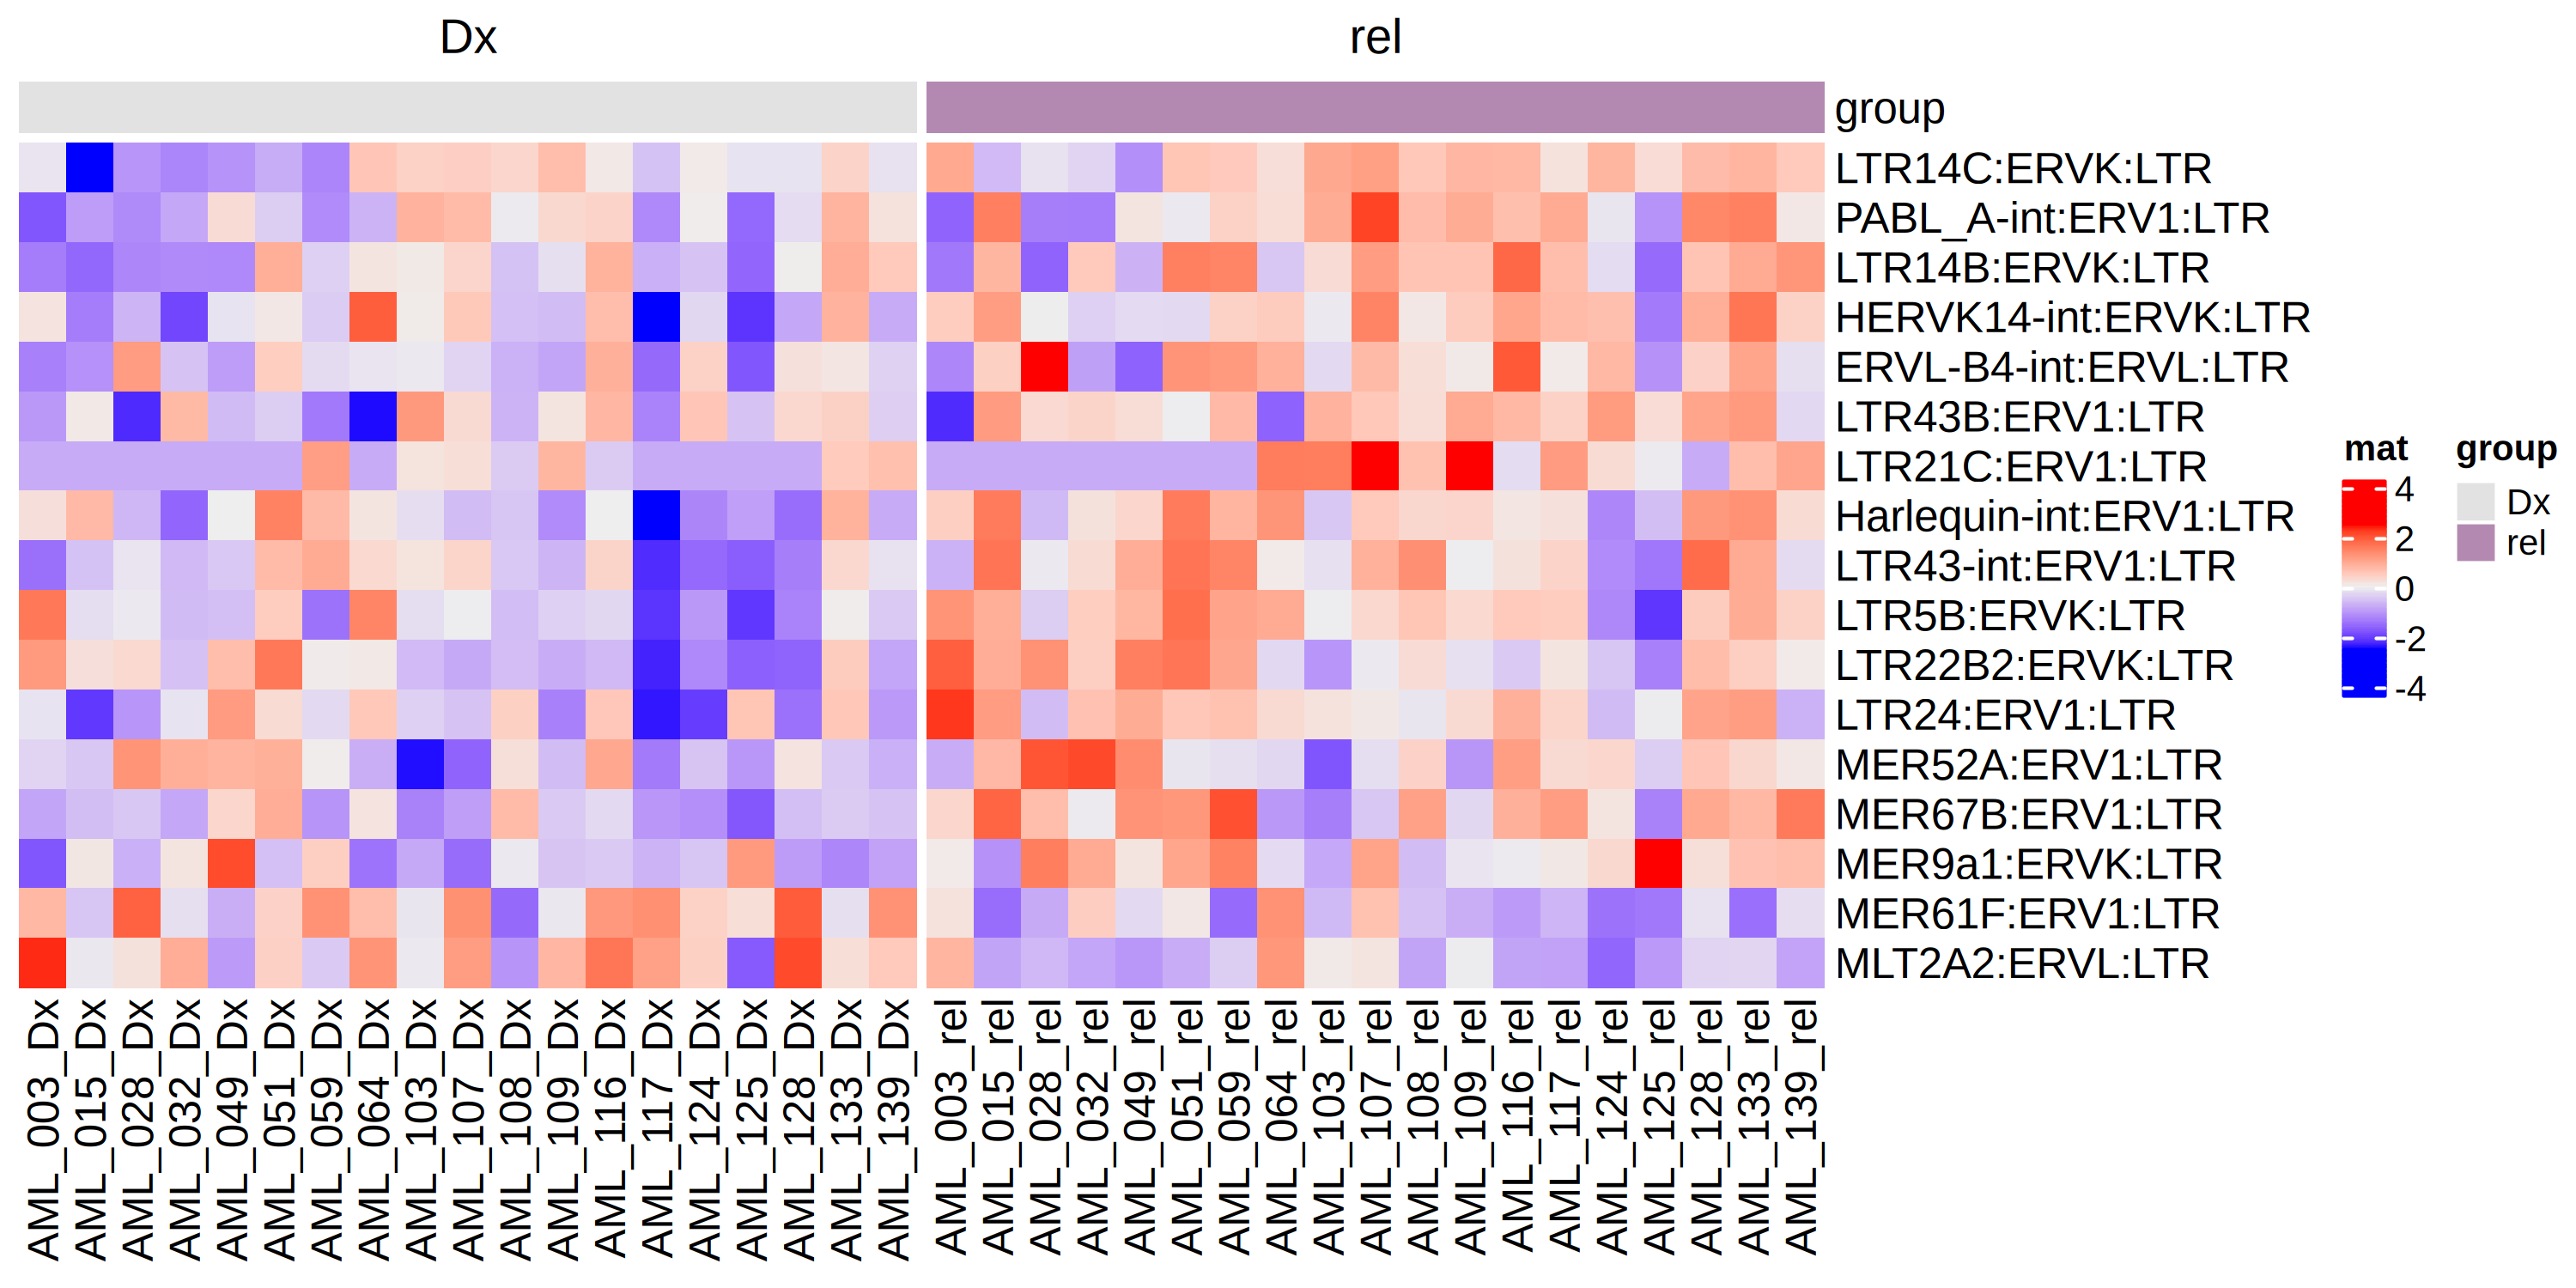

In [404]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)

dsn_row = deg_relapse_te[FDR < 0.1 & class_id %in% c('LTR'), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sort = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sort$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 3] = 3
plotdat[plotdat < -3] = -3

column_ha = HeatmapAnnotation(df = dsn_sort[, 'group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, cluster_rows = T,  
        show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sort$group, levels = c('Dx', 'rel')))


In [406]:
table(sign(dsn_row$logFC))


-1  1 
 2 15 

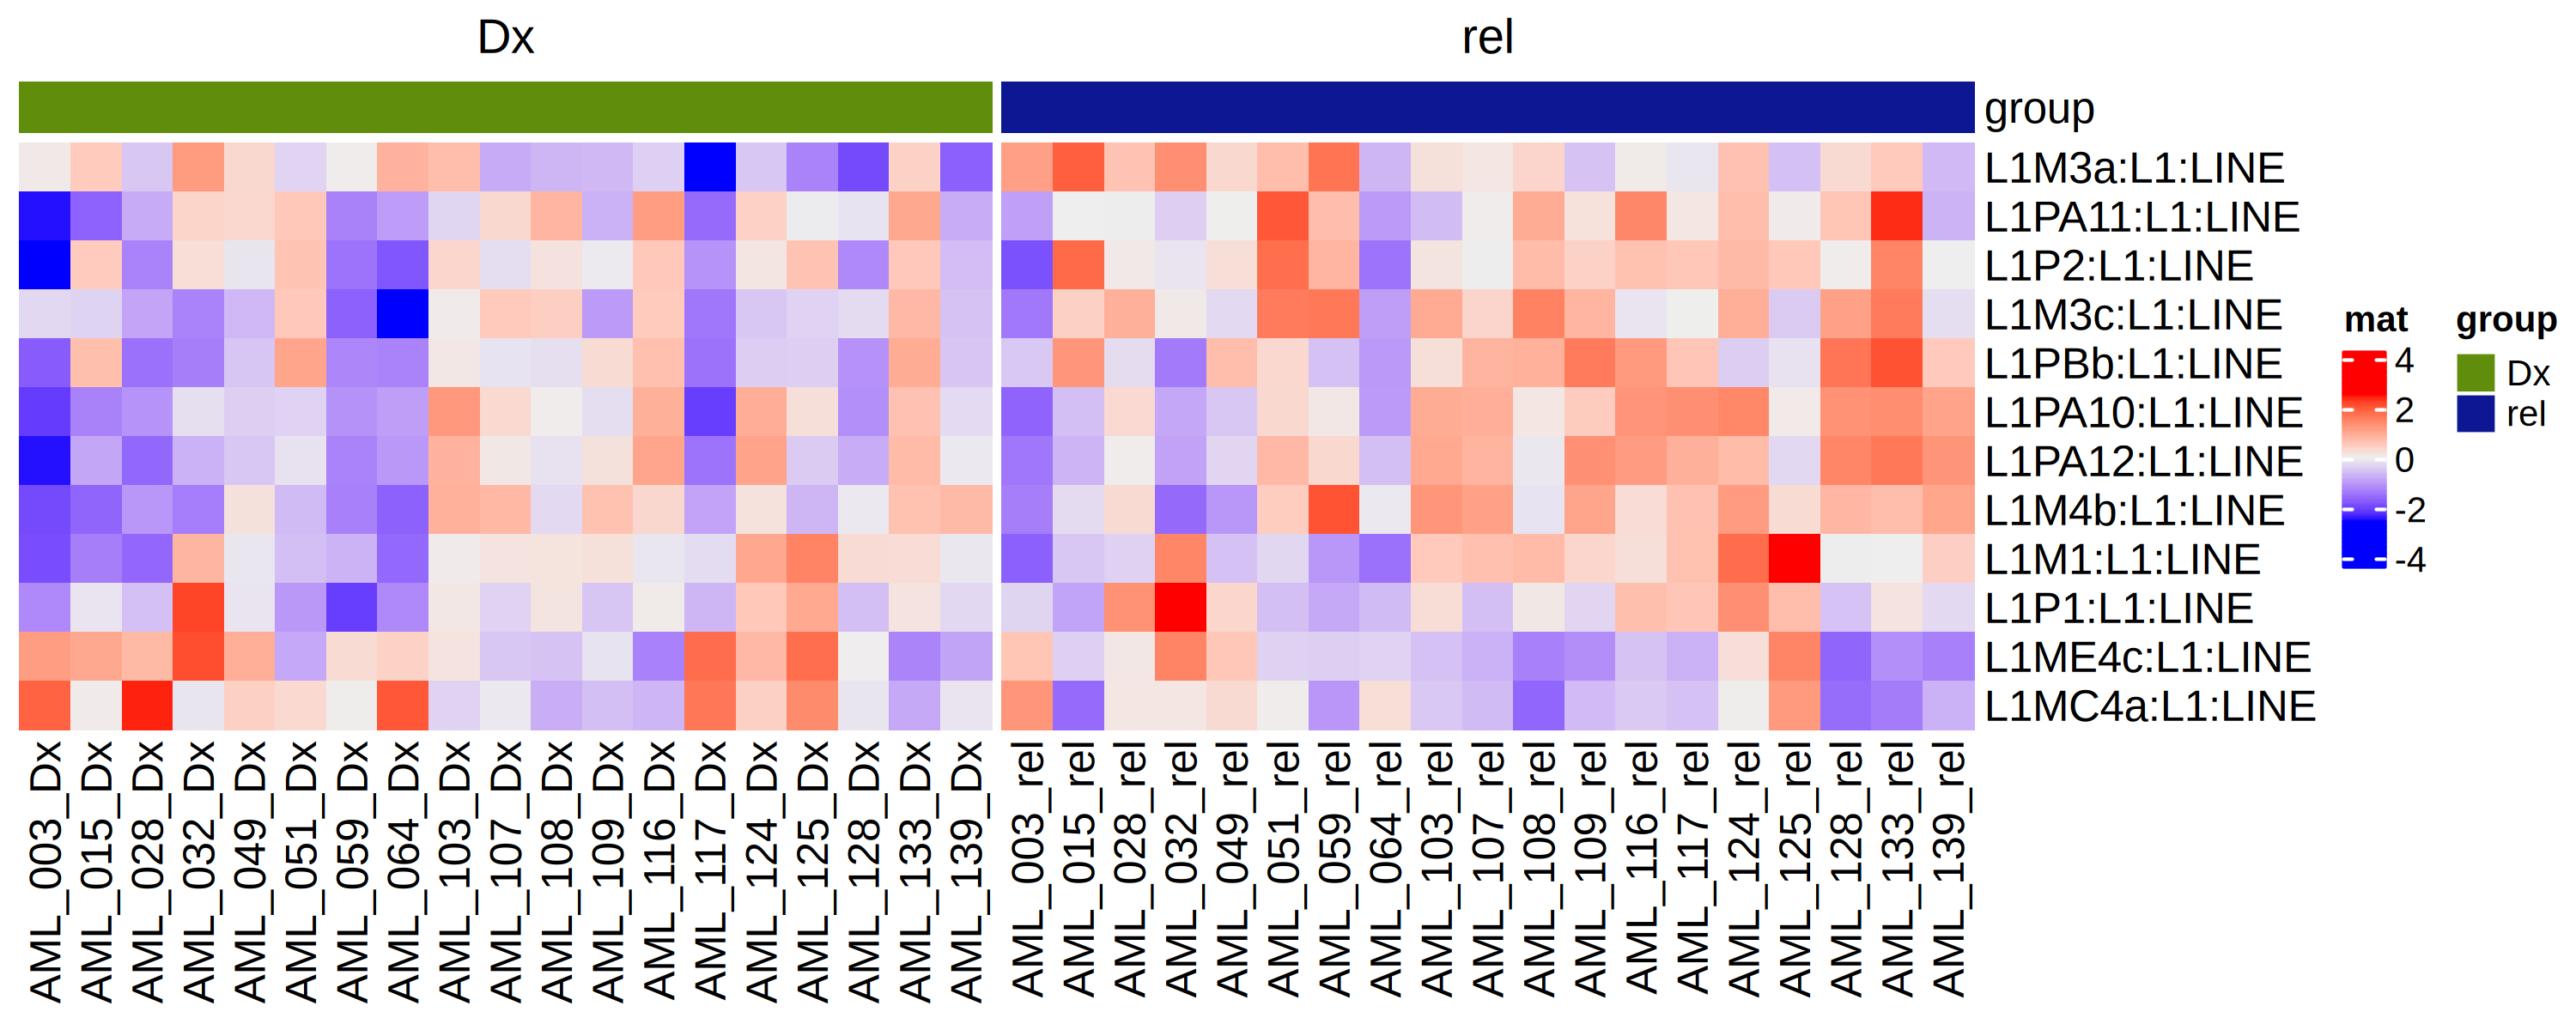

In [397]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)

dsn_row = deg_relapse_te[FDR < 0.1 & class_id %in% c('LINE'), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sort = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sort$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 3] = 3
plotdat[plotdat < -3] = -3

column_ha = HeatmapAnnotation(df = dsn_sort[, 'group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, cluster_rows = T,  
        show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sort$group, levels = c('Dx', 'rel')))


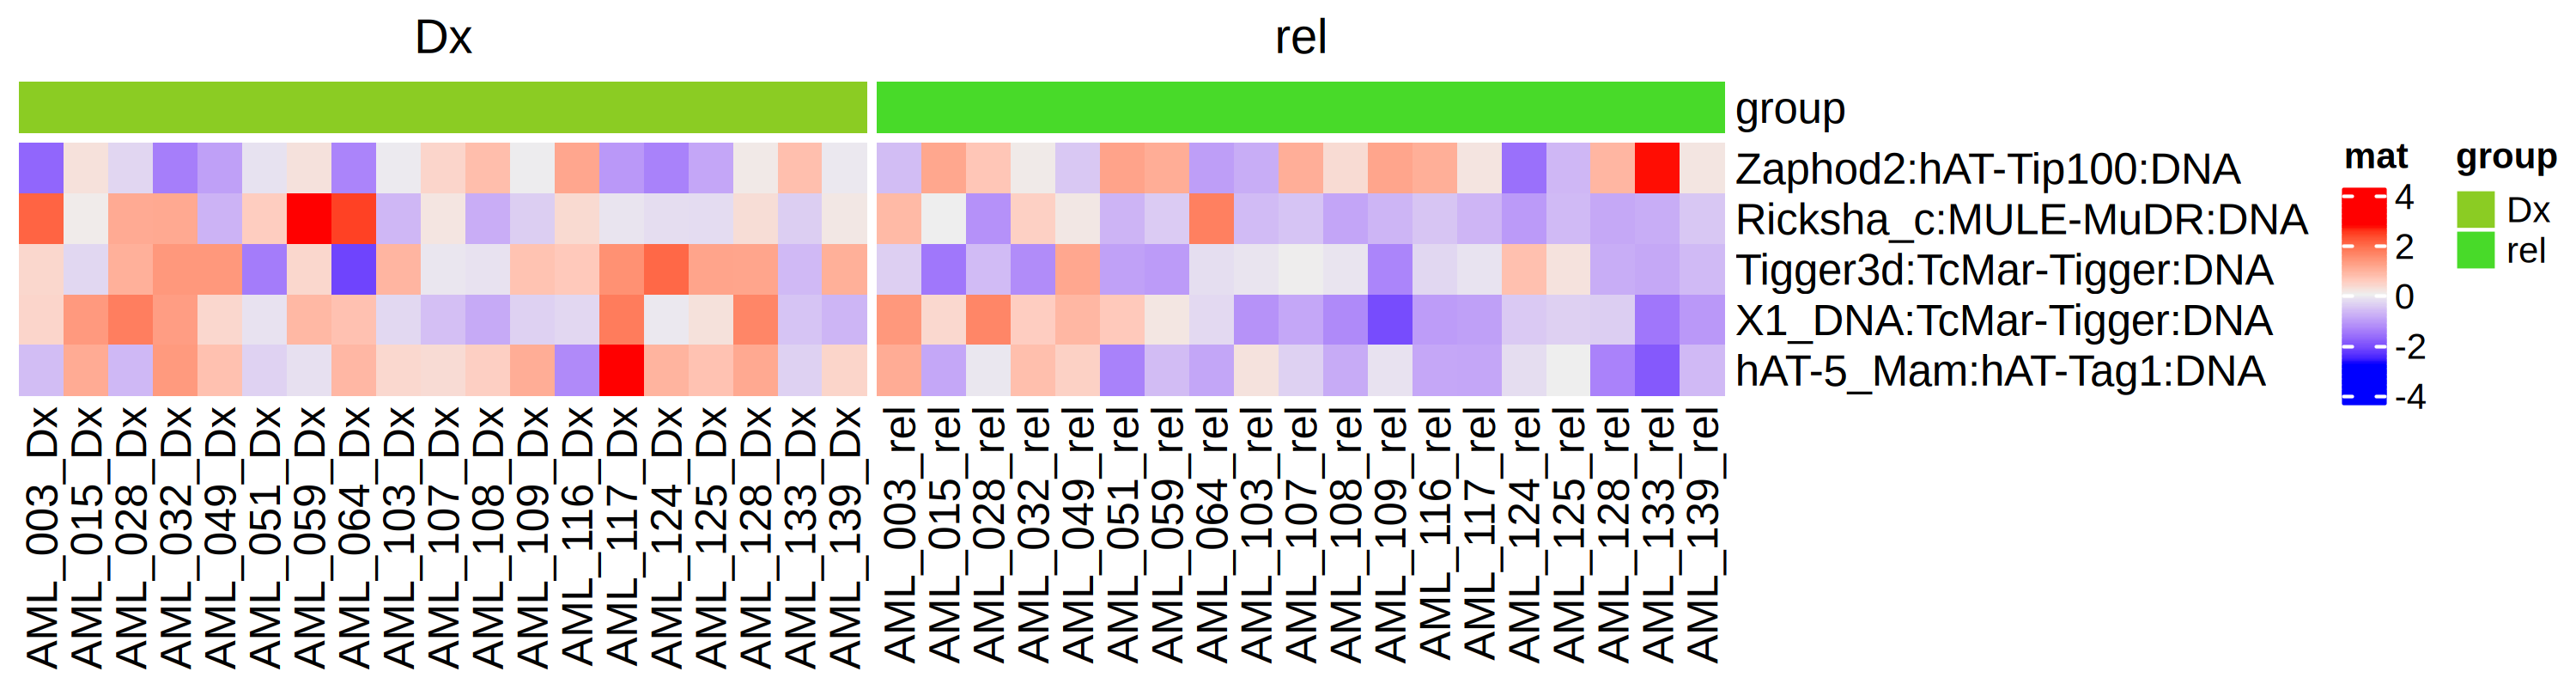

In [402]:
options(repr.plot.width = 10, repr.plot.height = 2.7, repr.plot.res = 300)

dsn_row = deg_relapse_te[FDR < 0.1 & class_id %in% c('DNA'), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sort = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sort$sample_name]

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 3] = 3
plotdat[plotdat < -3] = -3

column_ha = HeatmapAnnotation(df = dsn_sort[, 'group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, cluster_rows = T,  
        show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sort$group, levels = c('Dx', 'rel')))


Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."


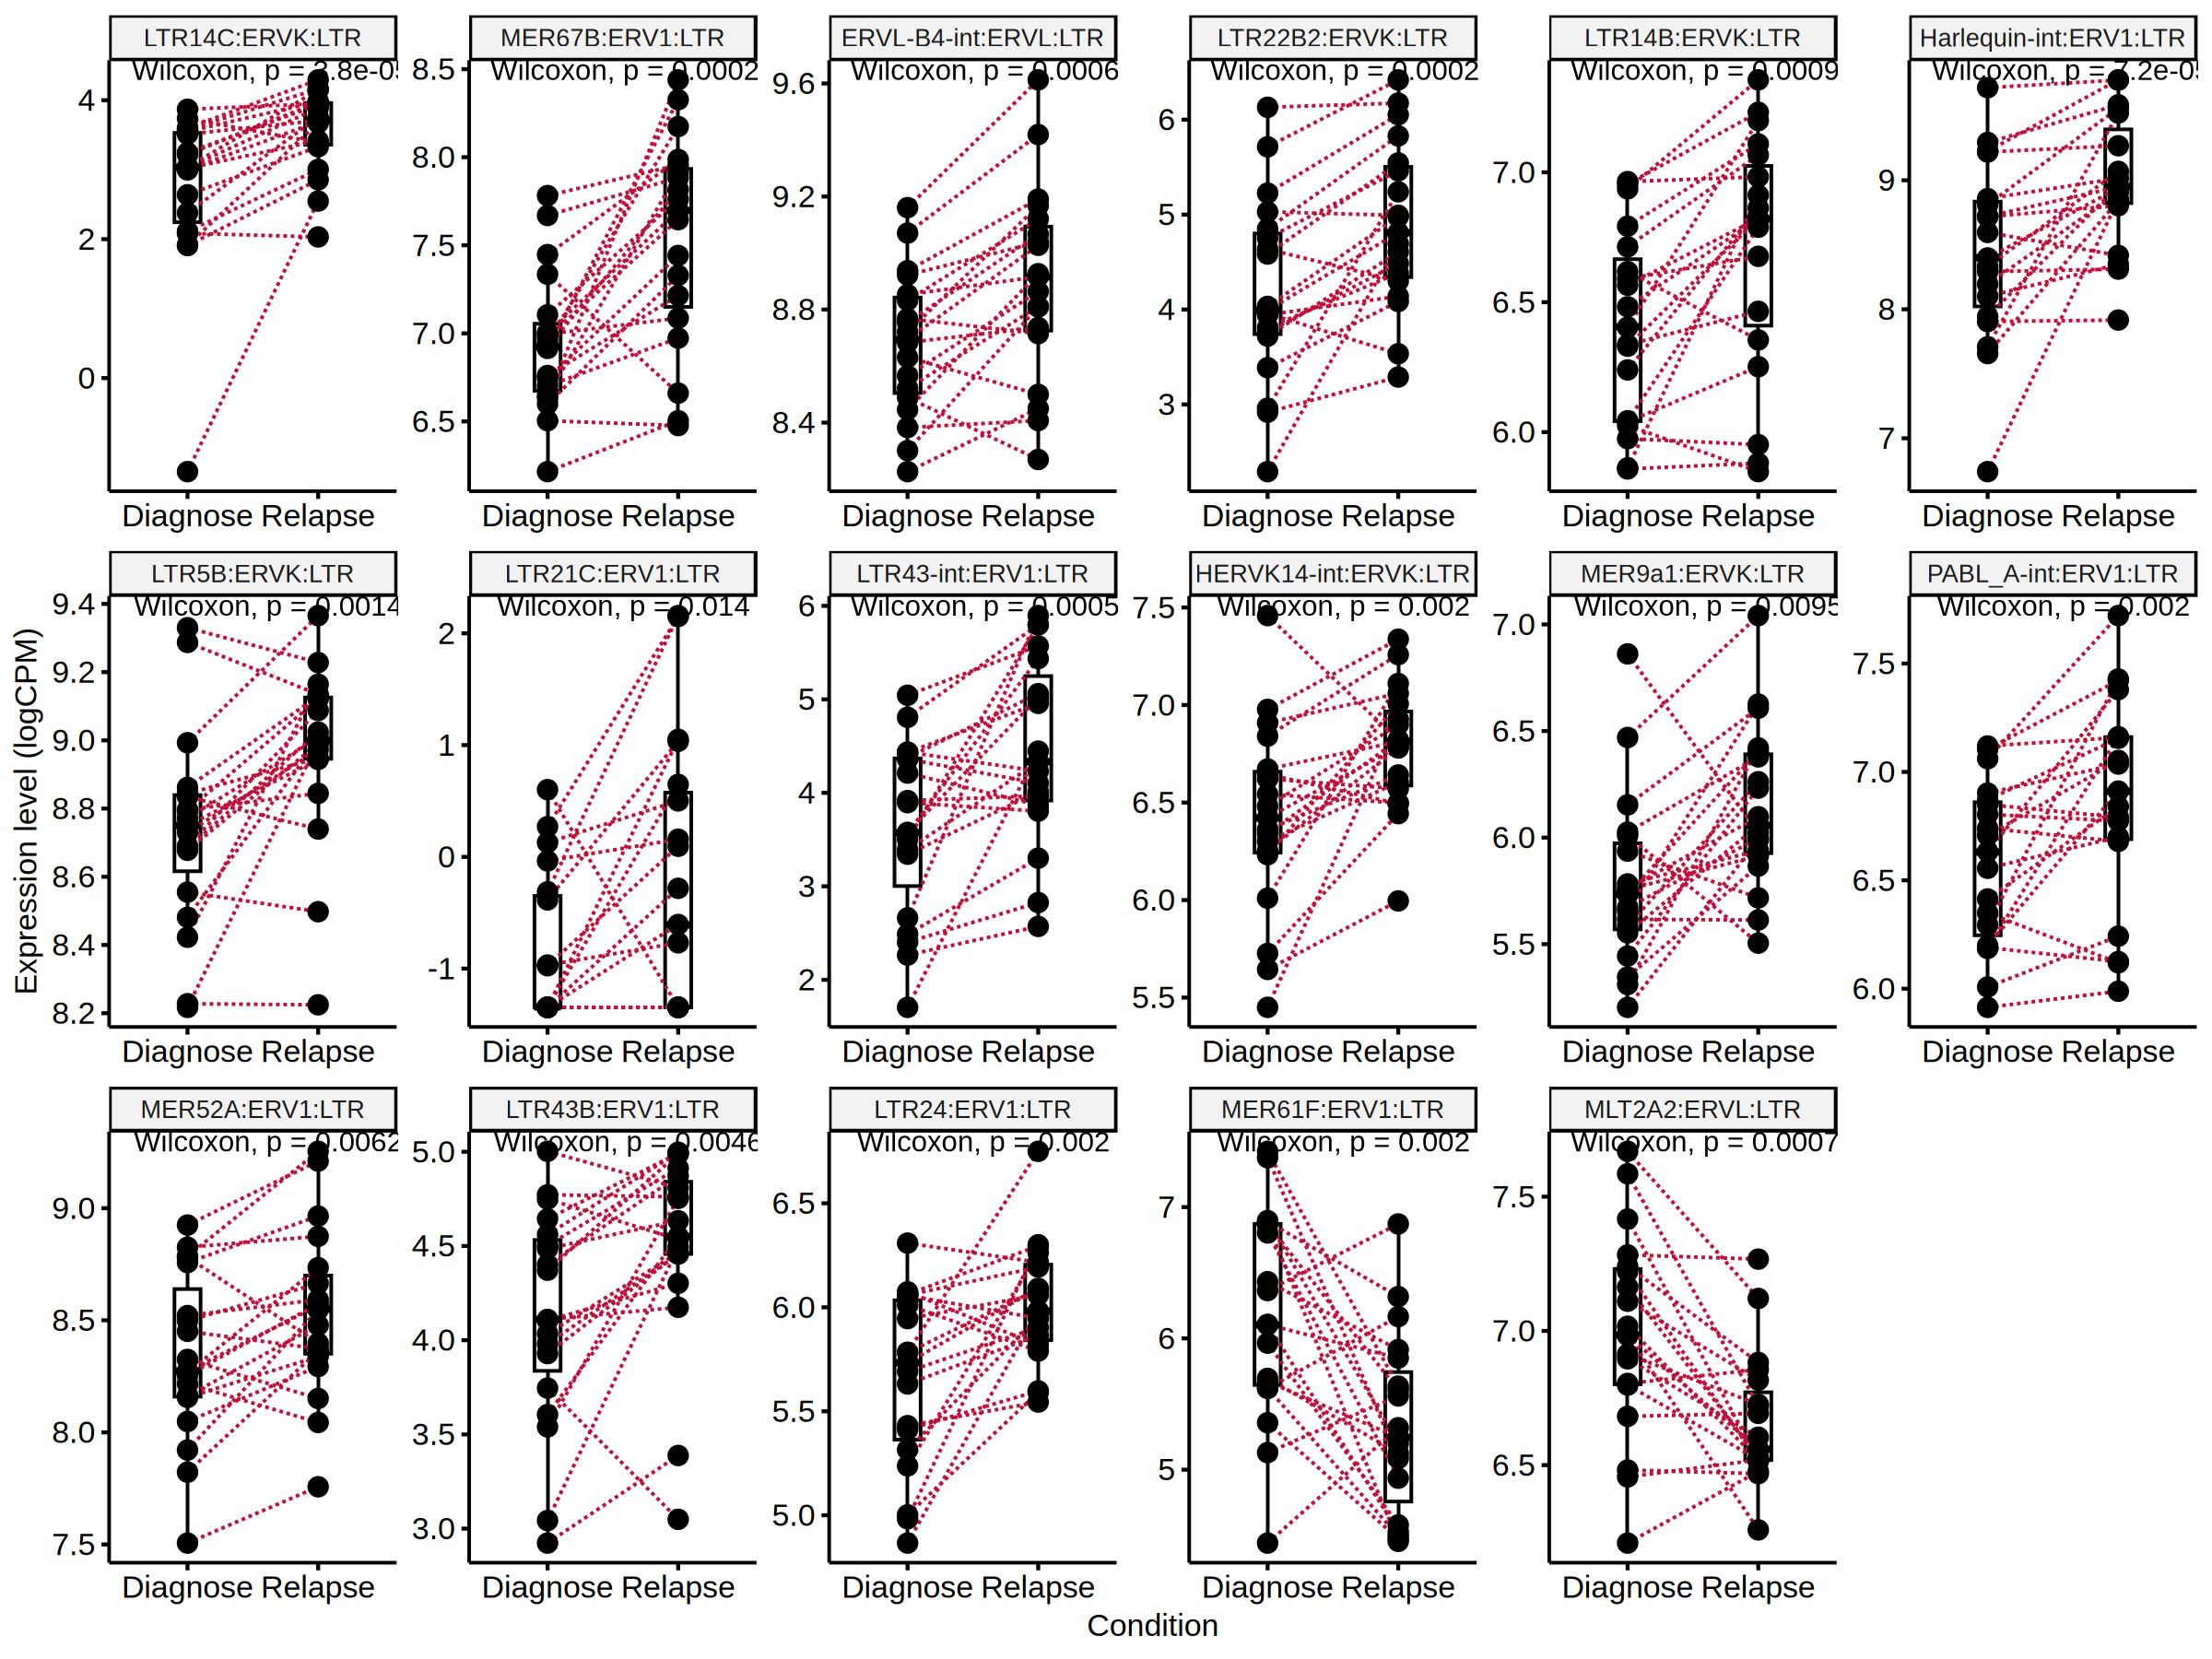

In [442]:
dsn_row = deg_relapse_te[FDR < 0.1 & class_id == 'LTR', ]
dsn_row = dsn_row[order(-sign(logFC)), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sorted$sample_name]
plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]
plotdat[, patient := sub('(AML_\\d+)_.*', '\\1', Var2) ]
plotdat = dcast(plotdat, Var1 + patient ~ group, value.var = 'value')
setnames(plotdat, c('TE gene', 'patient', 'Diagnose', 'Relapse'))

options(repr.plot.width = 12, repr.plot.height = 9, repr.plot.res = 200)
ggpaired(plotdat, cond1 = 'Diagnose', cond2 = 'Relapse', width = .2, point.size = 3, line.color = '#C10F3A', linetype = 'dashed', palette = "npg" ) + 
stat_compare_means(paired = T) +
facet_wrap(~ `TE gene`, ncol = 6, scale = 'free') + ylab('Expression level (logCPM)')

telocal_sel = copy(dsn_row)
telocal_sel = add_ann(telocal_sel)

Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."


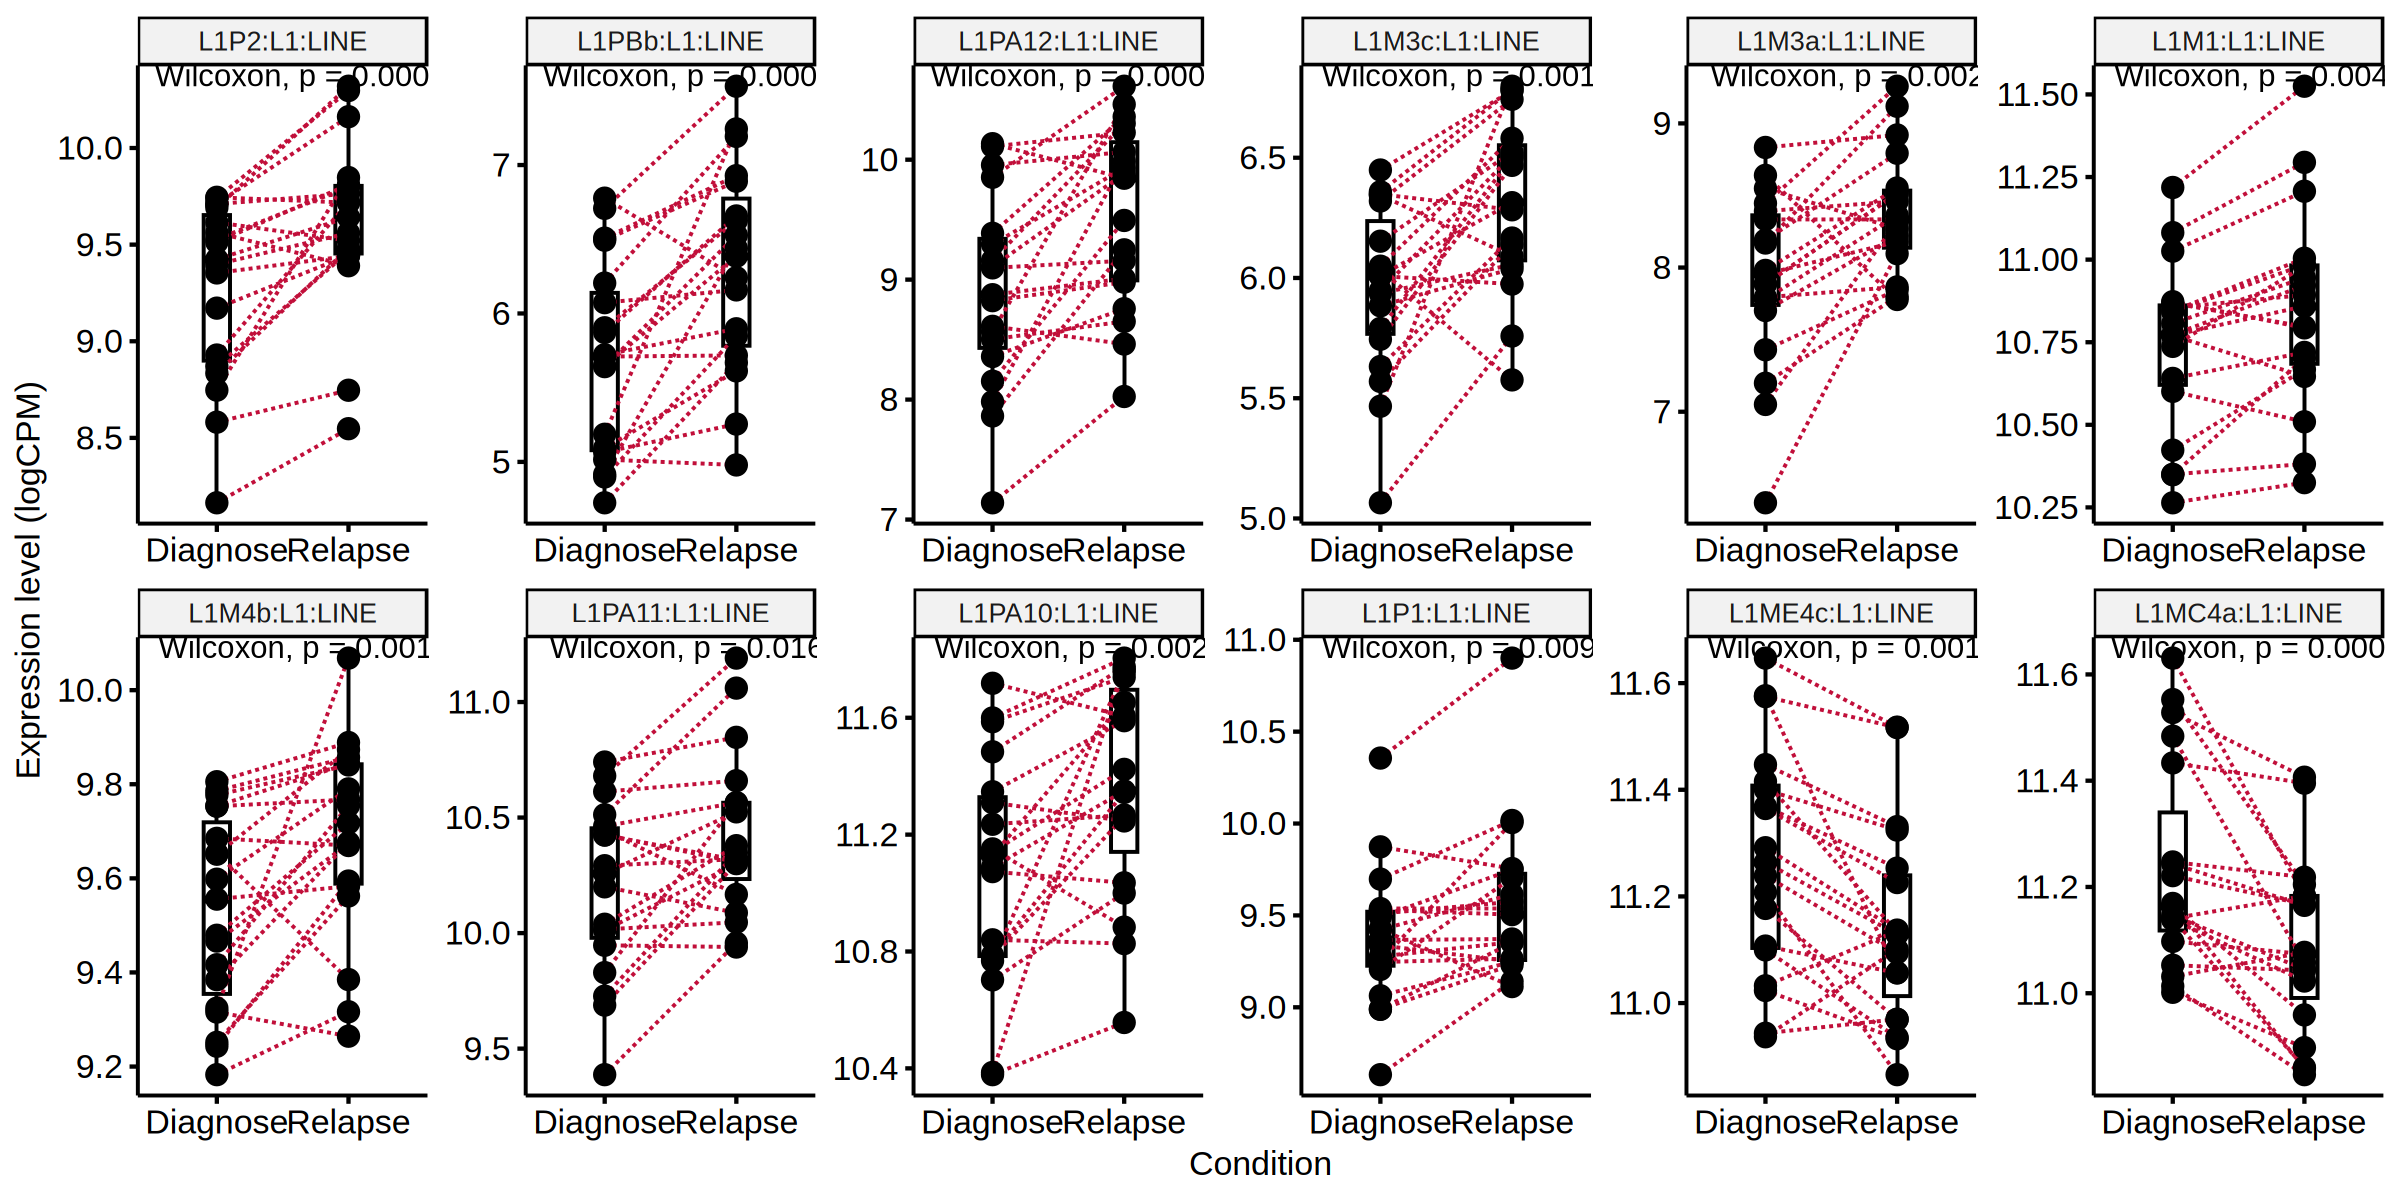

In [419]:
dsn_row = deg_relapse_te[FDR < 0.1 & class_id == 'LINE', ]
dsn_row = dsn_row[order(-sign(logFC)), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sorted$sample_name]
plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]
plotdat[, patient := sub('(AML_\\d+)_.*', '\\1', Var2) ]
plotdat = dcast(plotdat, Var1 + patient ~ group, value.var = 'value')
setnames(plotdat, c('TE gene', 'patient', 'Diagnose', 'Relapse'))

options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200)
ggpaired(plotdat, cond1 = 'Diagnose', cond2 = 'Relapse', width = .2, point.size = 3, line.color = '#C10F3A', linetype = 'dashed', palette = "npg" ) + 
stat_compare_means(paired = T) +
facet_wrap(~ `TE gene`, ncol = 6, scale = 'free') + ylab('Expression level (logCPM)')

telocal_sel = copy(dsn_row)

Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."


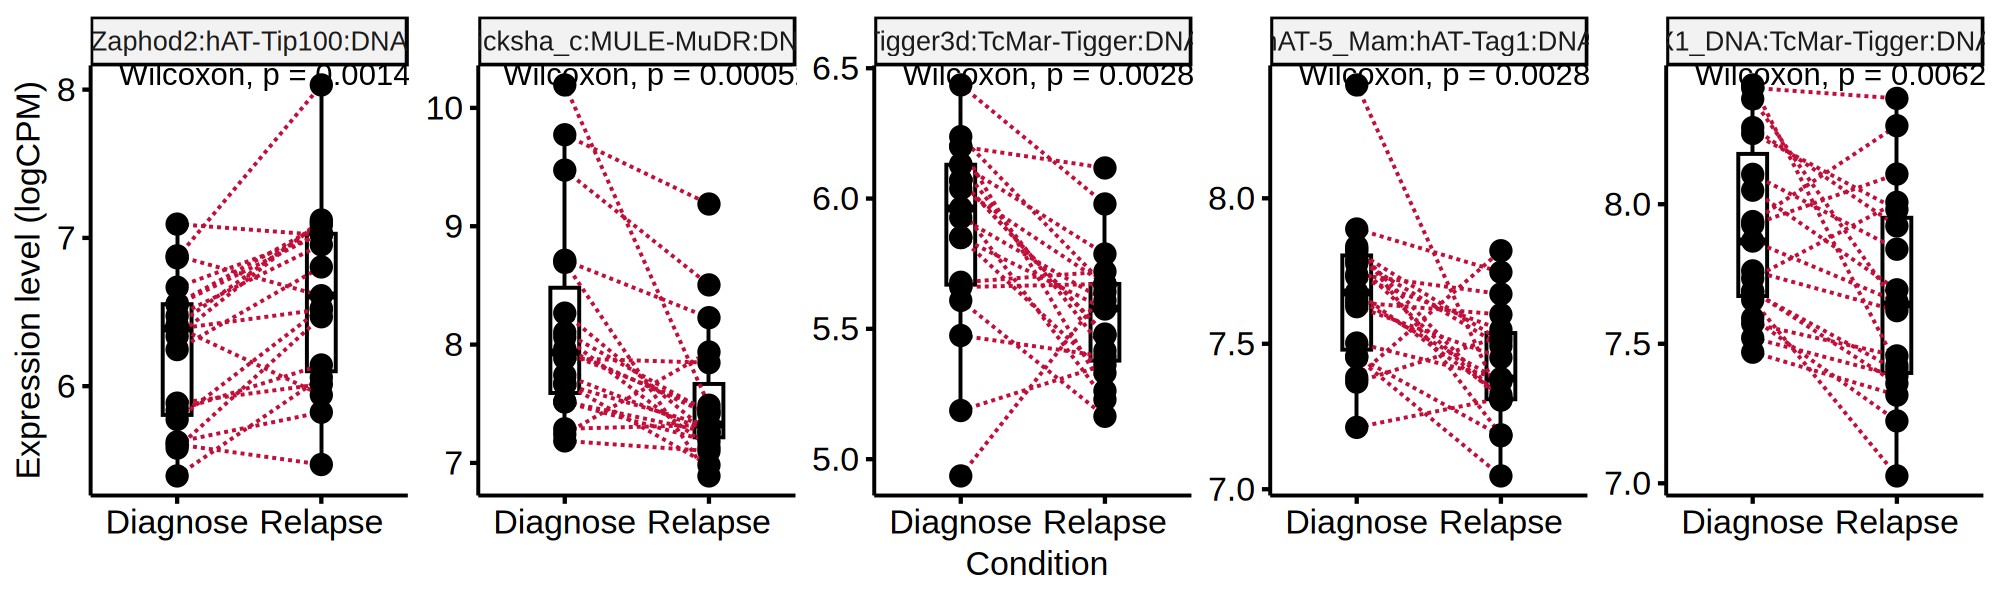

In [422]:
dsn_row = deg_relapse_te[FDR < 0.1 & class_id == 'DNA', ]
dsn_row = dsn_row[order(-sign(logFC)), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sorted$sample_name]
plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]
plotdat[, patient := sub('(AML_\\d+)_.*', '\\1', Var2) ]
plotdat = dcast(plotdat, Var1 + patient ~ group, value.var = 'value')
setnames(plotdat, c('TE gene', 'patient', 'Diagnose', 'Relapse'))

options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)
ggpaired(plotdat, cond1 = 'Diagnose', cond2 = 'Relapse', width = .2, point.size = 3, line.color = '#C10F3A', linetype = 'dashed', palette = "npg" ) + 
stat_compare_means(paired = T) +
facet_wrap(~ `TE gene`, ncol = 6, scale = 'free') + ylab('Expression level (logCPM)')

telocal_sel = copy(dsn_row)

Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


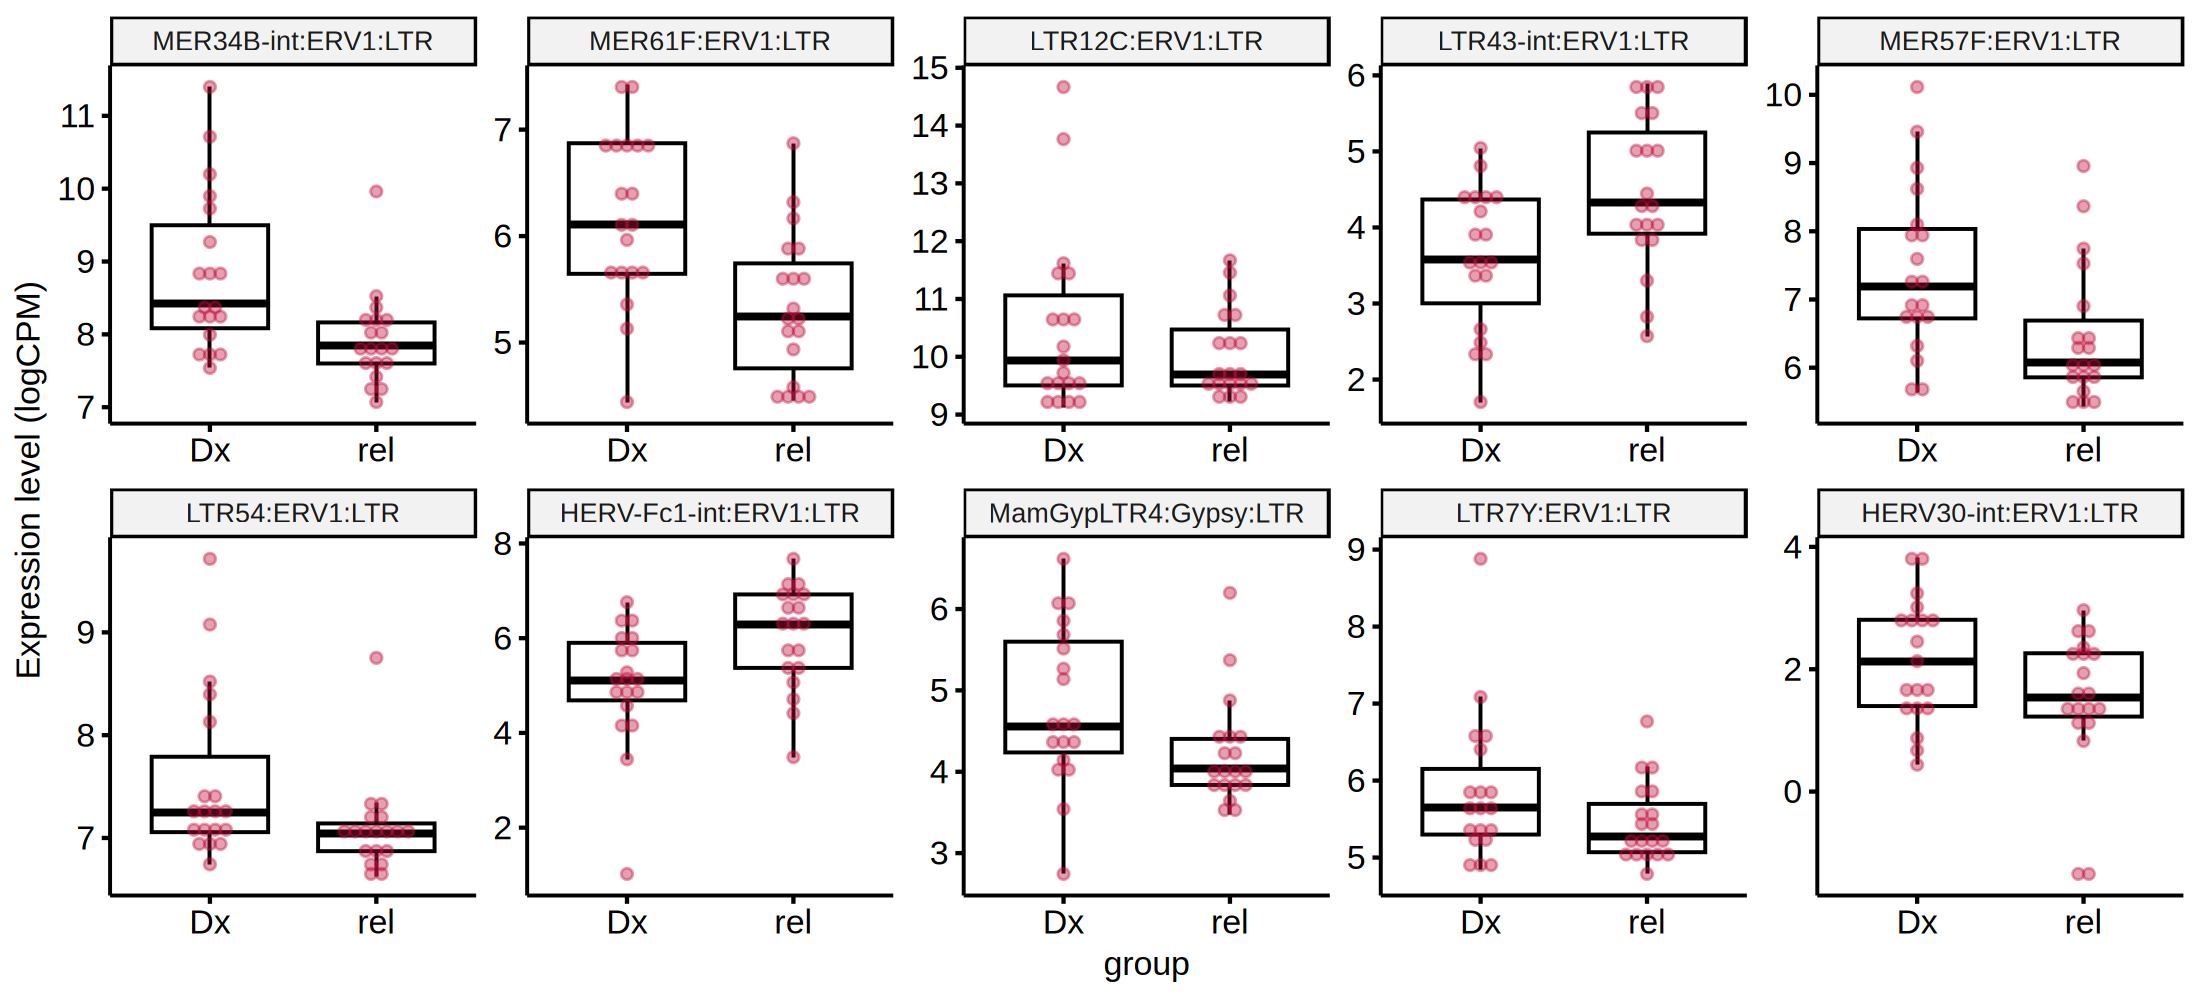

In [162]:
dsn_row = deg_relapse_te[abs(logFC) > .7 & PValue < 0.01, ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sort = dsn[order(group), ]
plotdat = logcpm_replase_te[dsn_row$rn, dsn_sort$sample_name][1:10, ]
plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]

options(repr.plot.width = 11, repr.plot.height = 5, repr.plot.res = 200)
gg = ggpair(plotdat, cond1 = 'group', y = 'value', add = 'dotplot', outlier.shape = NA, add.params = list(color = '#C10F3A', alpha = .4)) + 
facet_wrap(~ Var1, ncol = 5, scale = 'free') + ylab('Expression level (logCPM)')
gg

tecount_sel = copy(dsn_row)

# read telocal file


In [254]:
telocal_list = lapply(dsn[, telocal_file], function (fname) {
    tmp = fread(fname)
    setnames(tmp, 1, 'gene')
    setnames(tmp, 2, 'count')
    tmp
})
names(telocal_list) = dsn[, sample_name]
telocal_dt = rbindlist(telocal_list, idcol = T)


In [262]:
count_dt = dcast(formula = gene ~ .id, value.var = 'count', telocal_dt) 
count_df = setDF(count_dt[, 2:ncol(count_dt)], rownames = count_dt$gene)
head(count_dt)


gene                                         AML_003_Dx AML_003_rel
1 (CATTC)n:(CATTC)n:Satellite:Satellite        0          0          
2 (CATTC)n_dup100:(CATTC)n:Satellite:Satellite 0          0          
3 (CATTC)n_dup101:(CATTC)n:Satellite:Satellite 0          0          
4 (CATTC)n_dup102:(CATTC)n:Satellite:Satellite 0          0          
5 (CATTC)n_dup103:(CATTC)n:Satellite:Satellite 0          0          
6 (CATTC)n_dup104:(CATTC)n:Satellite:Satellite 0          0          
  AML_015_Dx AML_015_rel AML_028_Dx AML_028_rel AML_032_Dx AML_032_rel
1 0          0           0          0           0          0          
2 0          0           0          0           0          0          
3 0          0           0          0           0          0          
4 0          0           0          0           0          0          
5 0          0           0          0           0          0          
6 0          0           0          0           0          0          
  AML_049_Dx ⋯ AML_124_Dx AML_124_rel AML_125_Dx AML_125_rel AML_128_Dx
1 0          ⋯ 0          0           0          0           0         
2 0          ⋯ 0          0           0          0           0         
3 0          ⋯ 0          0           0          0           0         
4 0          ⋯ 0          0           0          0           0         
5 1          ⋯ 0          0           0          0           0         
6 0          ⋯ 0          0           0          0           0         
  AML_128_rel AML_133_Dx AML_133_rel AML_139_Dx AML_139_rel
1 0           0          0           0          0          
2 0           0          0           0          0          
3 0           0          0           0          0          
4 0           0          0           0          0          
5 0           0          0           0          0          
6 0           0          0           0          0

In [263]:
count_dt[, class_id := unlist(strsplit(gene, ':'))[4], by = 1:nrow(count_dt) ]
count_dt[, family_id := unlist(strsplit(gene, ':'))[3], by = 1:nrow(count_dt) ]
count_dt[, gene_id := unlist(strsplit(gene, ':'))[2], by = 1:nrow(count_dt) ]
count_dt[, transcript_id := unlist(strsplit(gene, ':'))[1], by = 1:nrow(count_dt) ]
count_dt[, local_id := paste0(gene_id, ':', family_id, ':', class_id)]


In [364]:
count_dt_sel = count_dt[local_id %in% tecount_sel$rn, ]


In [365]:
row_sums = rowSums(count_dt_sel[, 2:39])


In [366]:
count_dt_sel2 = count_dt_sel[row_sums > 50, ]

In [367]:
count_dt_sel2_df = setDF(count_dt_sel2[, 2:39], rownames = count_dt_sel2$gene)

In [368]:
dim(count_dt_sel2)

[1] 409  44

# DEG TElocal

In [376]:
treatment = factor(dsn$group)
treatment = relevel(treatment, ref = 'Dx')
subject = factor(dsn$patient)
design <- model.matrix(~ subject + treatment)

dge = DGEList(counts=count_dt_sel2_df[, dsn$sample_name])
dge = estimateDisp(dge, design)
fit <- glmQLFit(dge, design)
qlf <- glmQLFTest(fit)
deg_relapse_local_te = topTags(qlf, n = nrow(dge))
deg_relapse_local_te = as.data.table(deg_relapse_local_te$table, keep.rownames = T)
dim(deg_relapse_local_te)
head(deg_relapse_local_te)


[1] 409   6

rn                                       logFC    logCPM    F       
1 LTR12C_dup410:LTR12C:ERV1:LTR            3.961359  9.534510 33.92836
2 LTR12C_dup254:LTR12C:ERV1:LTR            1.767521 10.826385 14.45655
3 LTR43_dup228:LTR43-int:ERV1:LTR          2.126817 10.936266 14.12814
4 LTR12C_dup1914:LTR12C:ERV1:LTR           2.291787  9.982645 13.82045
5 HERV-Fc1_LTR1_dup9:HERV-Fc1-int:ERV1:LTR 1.595325 14.976904 13.09006
6 LTR12C_dup1891:LTR12C:ERV1:LTR           1.434663 12.523825 12.29788
  PValue       FDR         
1 8.384565e-07 0.0003429287
2 4.212319e-04 0.0590904132
3 5.003761e-04 0.0590904132
4 5.779014e-04 0.0590904132
5 7.242836e-04 0.0592464008
6 1.010248e-03 0.0688652076

In [377]:
deg_relapse_local_te = add_ann(deg_relapse_local_te)
head(xx)

rn                                       logFC    logCPM    F       
1 LTR12C_dup410:LTR12C:ERV1:LTR            3.961359  9.534510 33.92836
2 LTR12C_dup254:LTR12C:ERV1:LTR            1.767521 10.826385 14.45655
3 LTR43_dup228:LTR43-int:ERV1:LTR          2.126817 10.936266 14.12814
4 LTR12C_dup1914:LTR12C:ERV1:LTR           2.291787  9.982645 13.82045
5 HERV-Fc1_LTR1_dup9:HERV-Fc1-int:ERV1:LTR 1.595325 14.976904 13.09006
6 LTR12C_dup1891:LTR12C:ERV1:LTR           1.434663 12.523825 12.29788
  PValue       FDR          class_id family_id gene_id      tx_id             
1 8.384565e-07 0.0003429287 LTR      ERV1      LTR12C       LTR12C_dup410     
2 4.212319e-04 0.0590904132 LTR      ERV1      LTR12C       LTR12C_dup254     
3 5.003761e-04 0.0590904132 LTR      ERV1      LTR43-int    LTR43_dup228      
4 5.779014e-04 0.0590904132 LTR      ERV1      LTR12C       LTR12C_dup1914    
5 7.242836e-04 0.0592464008 LTR      ERV1      HERV-Fc1-int HERV-Fc1_LTR1_dup9
6 1.010248e-03 0.0688652076 LTR      ERV1      LTR12C       LTR12C_dup1891

In [383]:
dim(deg_relapse_local_te)

[1] 409  10

In [378]:
logcpm_replase_local_te = cpm(dge, normalized.lib.sizes = T, log = T)

# telocal heatmap

In [429]:
dsn_row = deg_relapse_local_te[FDR < 0.1, ]
table(dsn_row$class_id)
table(dsn_row$family_id)
table(dsn_row$gene_id)
table(sign(dsn_row$logFC))



LTR 
 37 


ERV1 
  37 


HERV-Fc1-int  HERV9NC-int       LTR12C    LTR43-int        LTR54        LTR7Y 
           1            2           15            4            8            1 
  MER34B-int       MER57F 
           3            3 


-1  1 
 4 33 

In [430]:
deg_relapse_local_te[, id := paste0(tx_id, ':', gene_id)]

In [380]:
head(plotdat)

AML_003_Dx AML_015_Dx AML_028_Dx AML_032_Dx AML_049_Dx AML_051_Dx 
  8.363713   8.363713   8.363713   8.363713   9.185394   8.363713

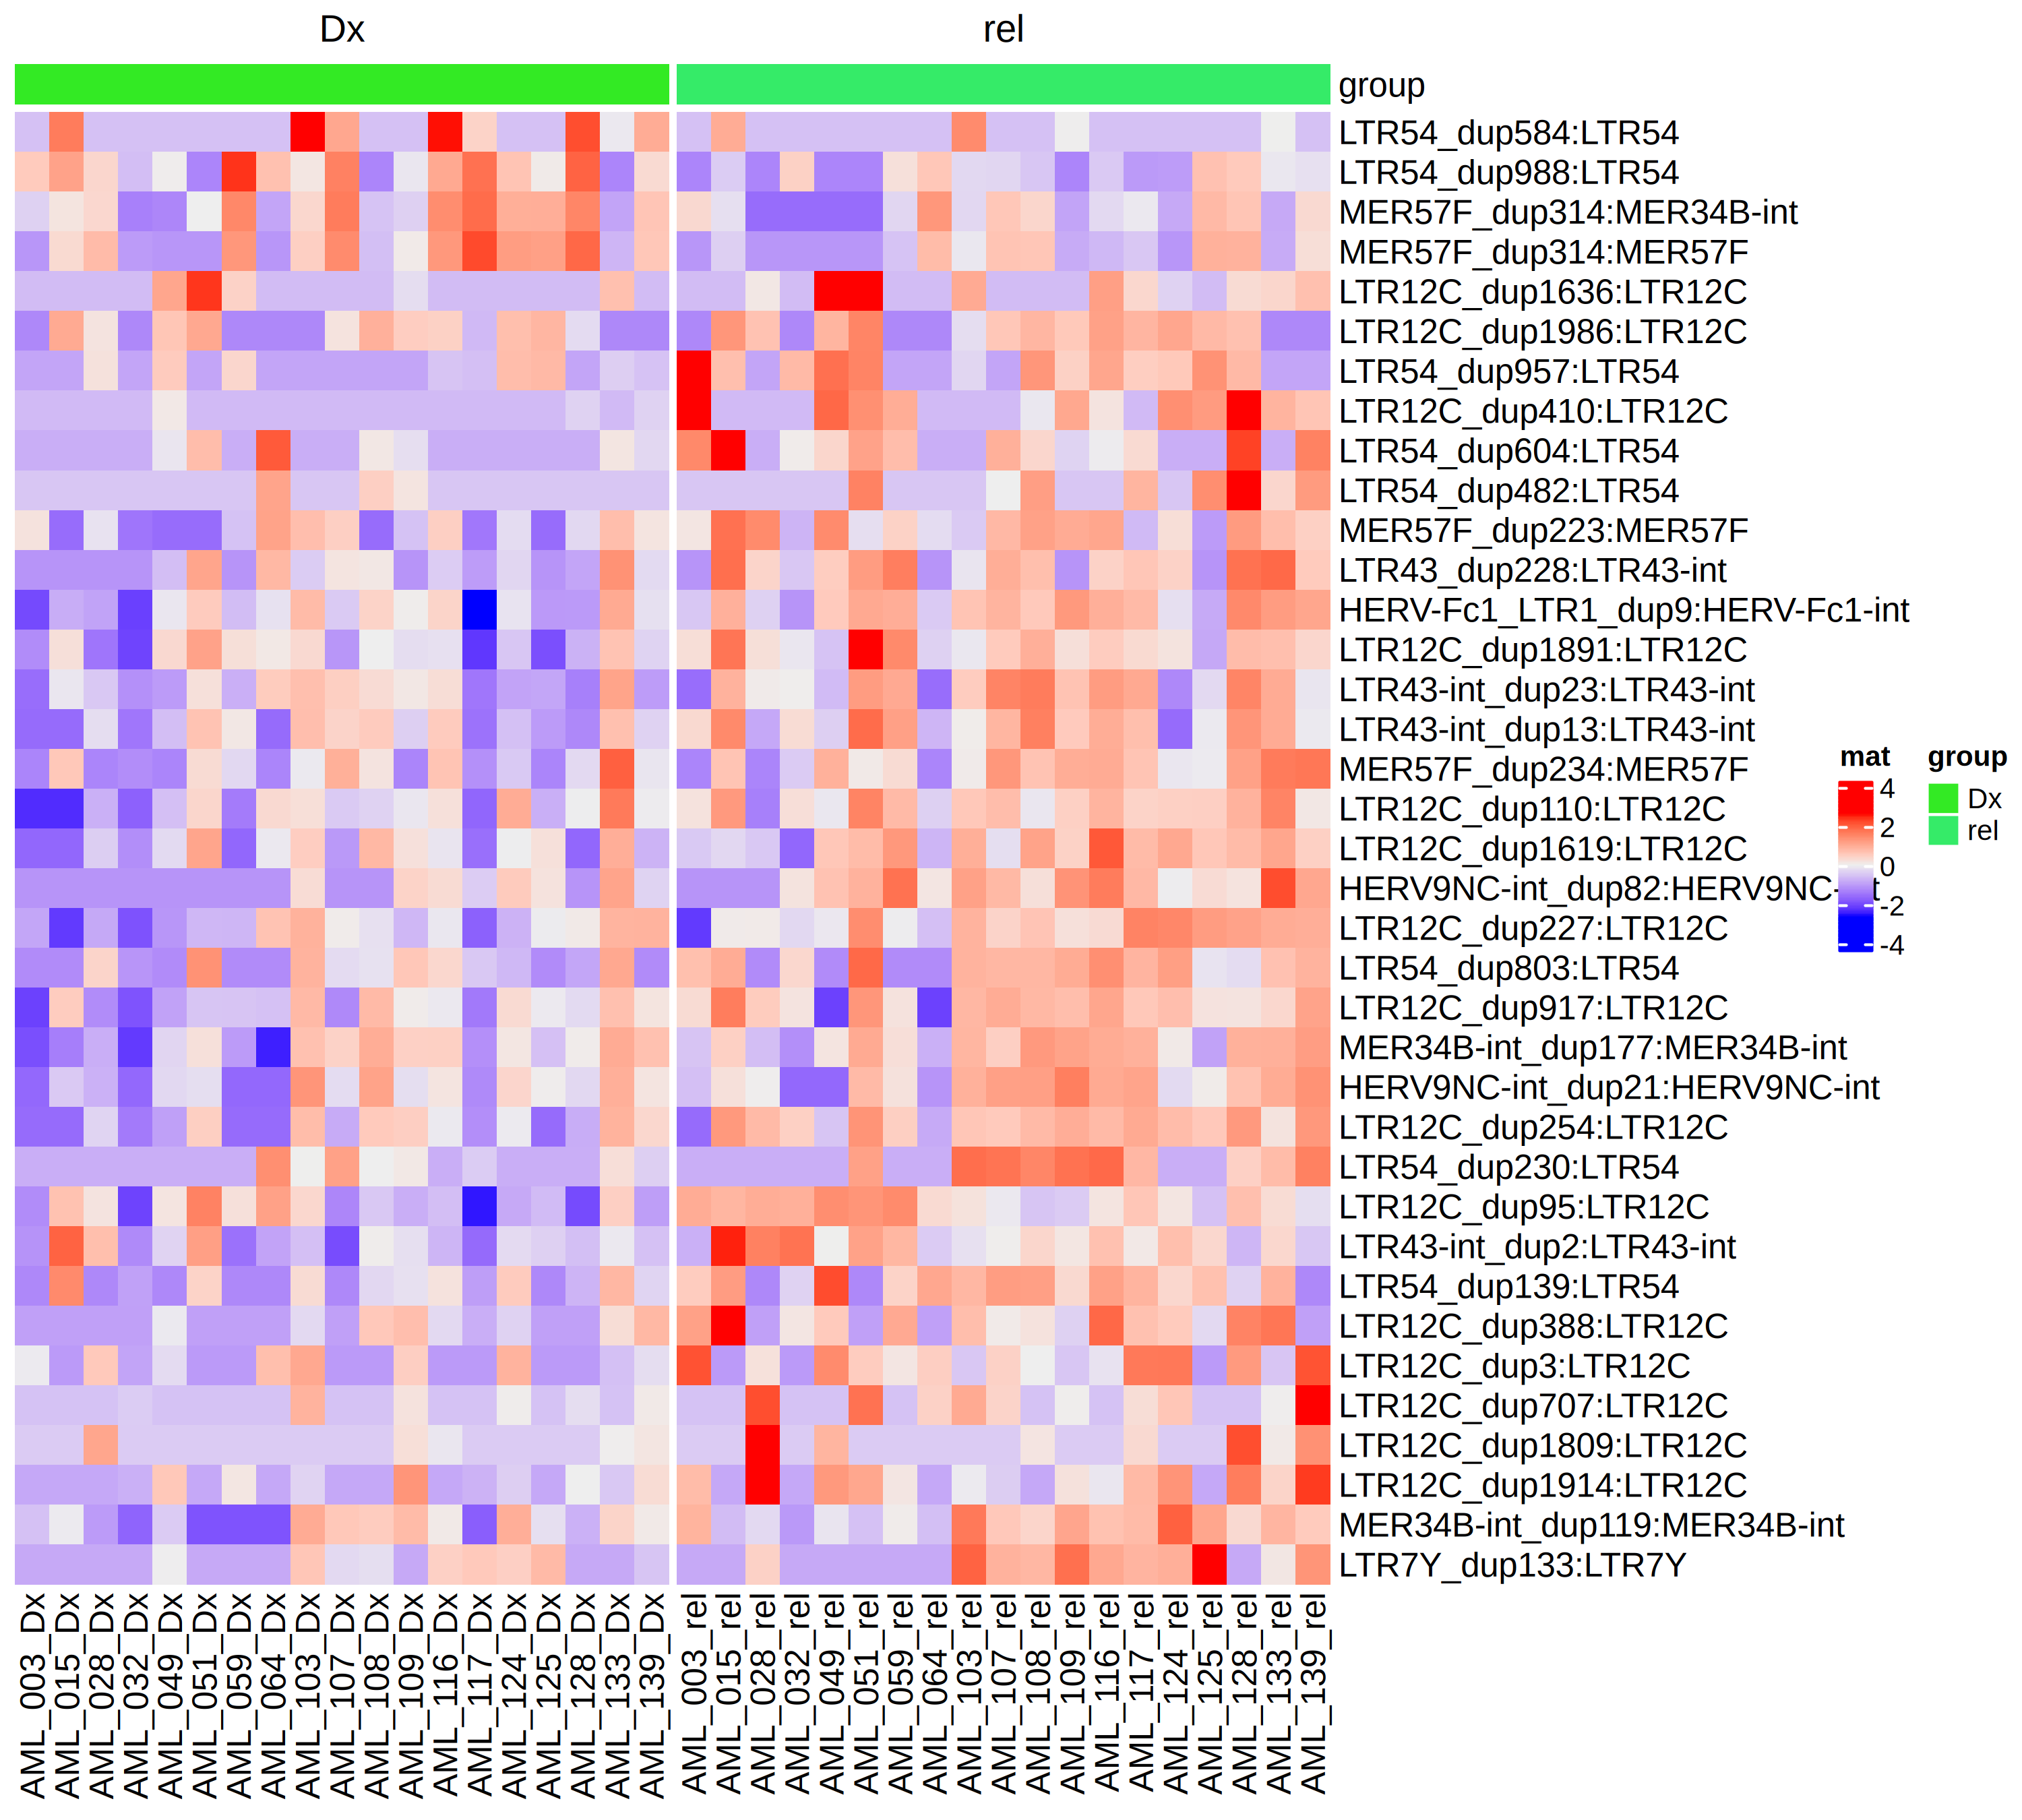

In [431]:
options(repr.plot.width = 10, repr.plot.height = 9, repr.plot.res = 300)

dsn_row = deg_relapse_local_te[FDR < 0.1, ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_local_te[dsn_row$rn, dsn_sorted$sample_name]
rownames(plotdat) = dsn_row$id

plotdat = scale_fun(plotdat) 
plotdat[plotdat > 5] = 5
plotdat[plotdat < -5] = -5

column_ha = HeatmapAnnotation(df = dsn_sorted[, 'group', drop = F])
Heatmap(plotdat, name = "mat", show_column_names = T, show_row_names = T, show_column_dend = F, cluster_columns  = F, cluster_rows = T,  
        show_row_dend = F, top_annotation = column_ha, column_split = factor(dsn_sort$group, levels = c('Dx', 'rel')))


Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."


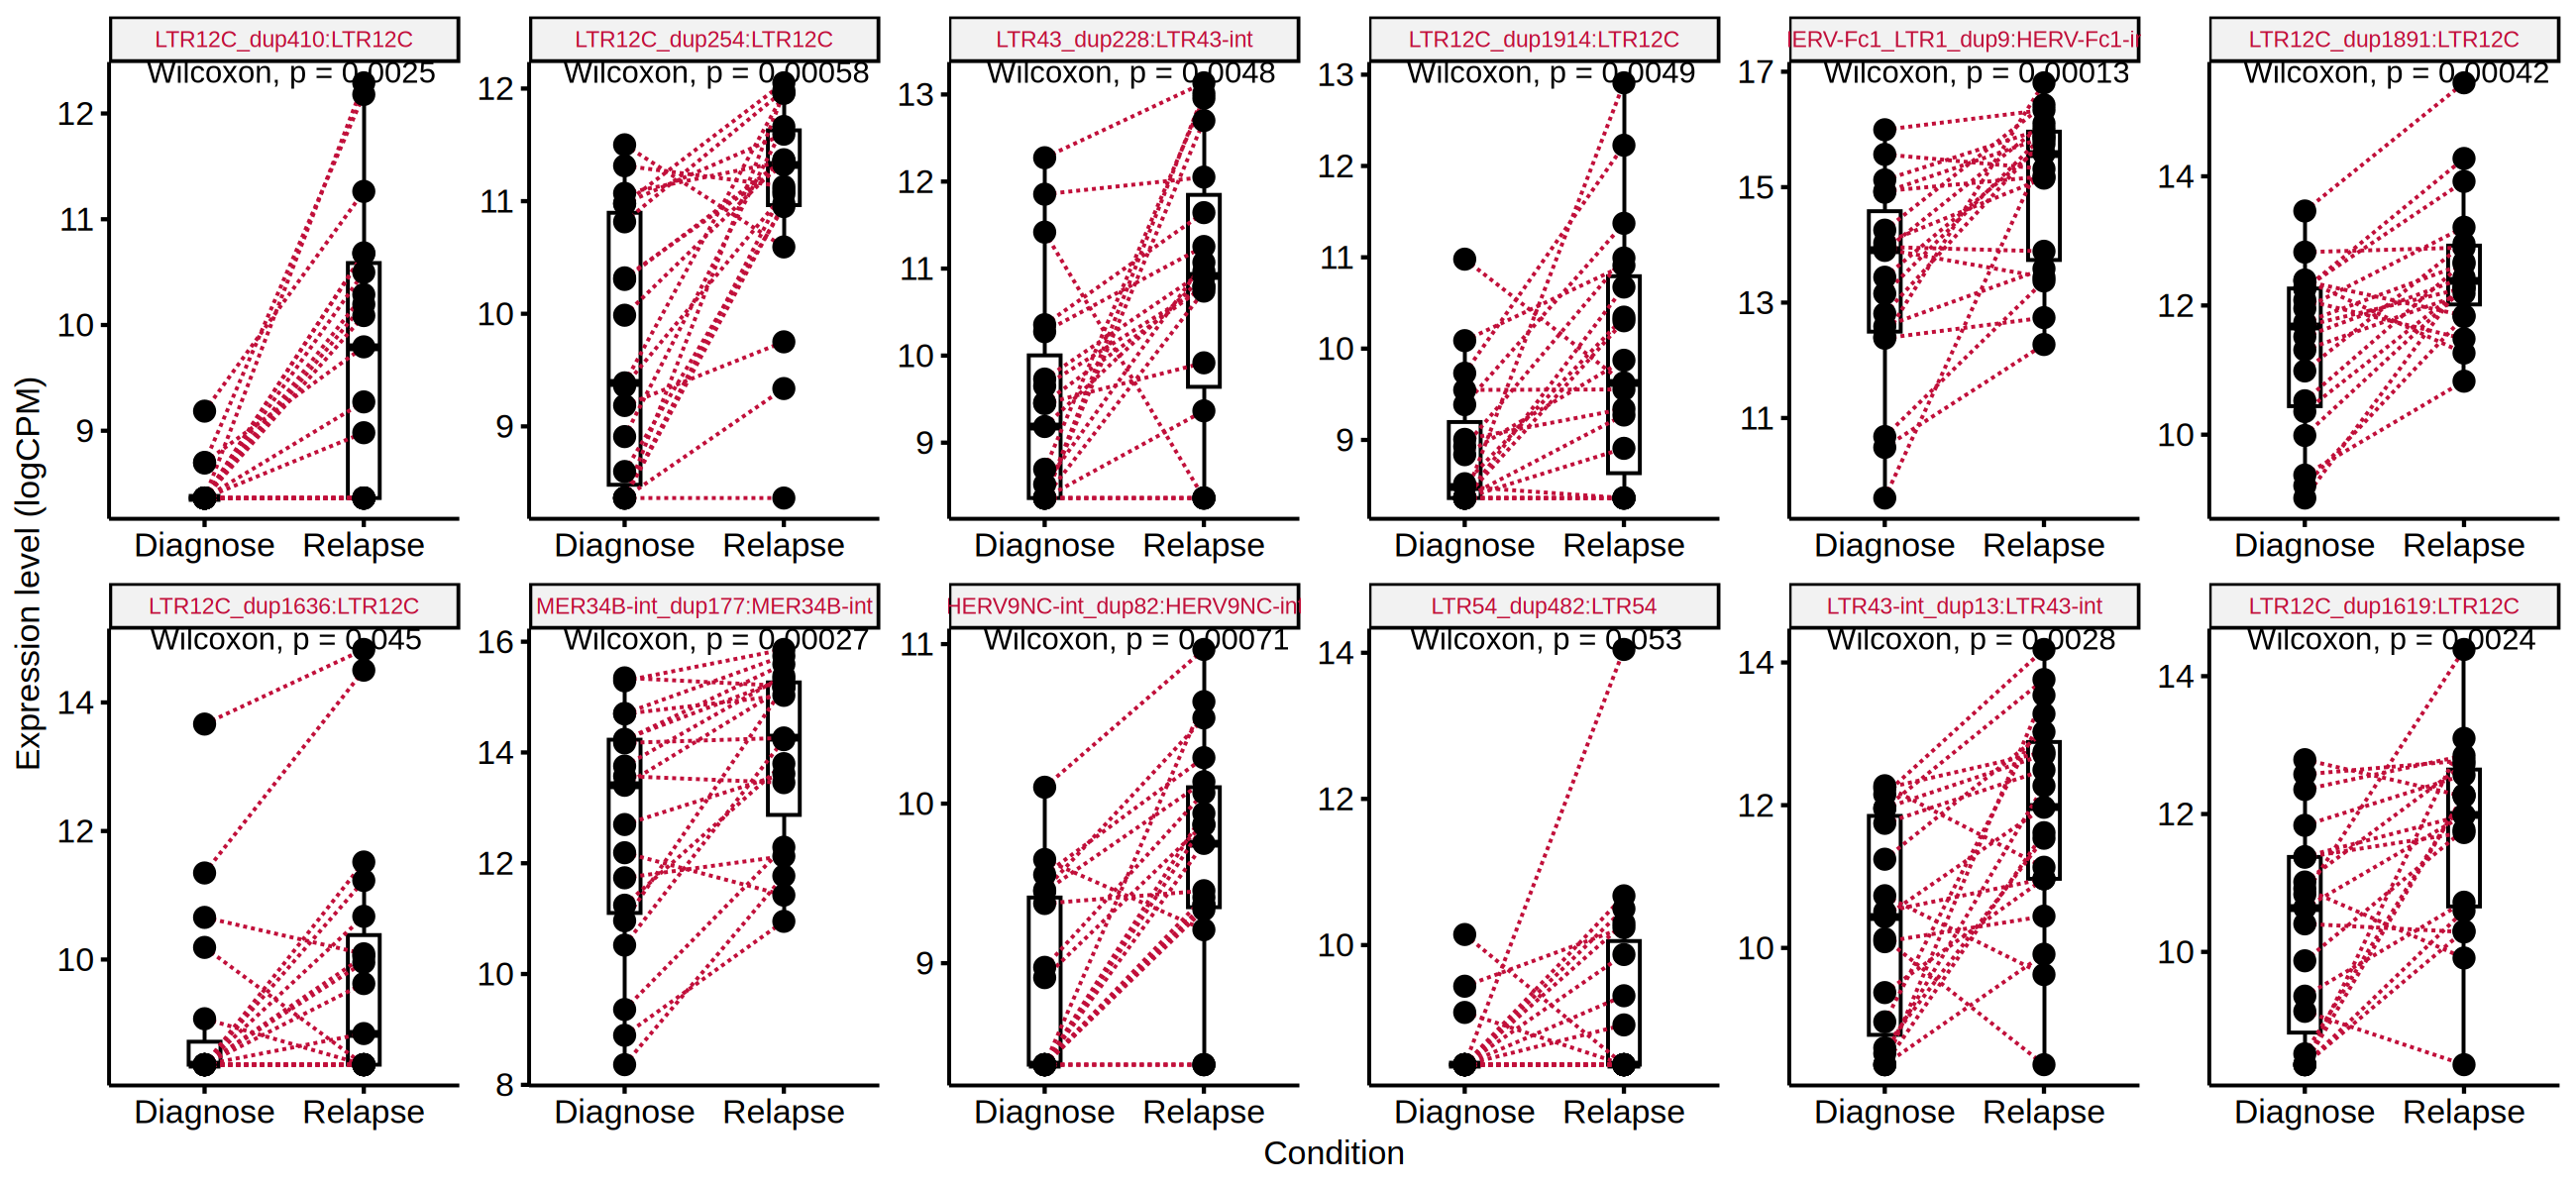

In [457]:
dsn_row = deg_relapse_local_te[FDR < 0.1 & logFC > 0, ][order(PValue), ][1:12, ]
dsn_row = dsn_row[order(class_id), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_local_te[dsn_row$rn, dsn_sorted$sample_name]
rownames(plotdat) = dsn_row$id

plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]
plotdat[, patient := sub('(AML_\\d+)_.*', '\\1', Var2) ]
plotdat = dcast(plotdat, Var1 + patient ~ group, value.var = 'value')
setnames(plotdat, c('TE gene', 'patient', 'Diagnose', 'Relapse'))

options(repr.plot.width = 13, repr.plot.height = 6, repr.plot.res = 200)
ggpaired(plotdat, cond1 = 'Diagnose', cond2 = 'Relapse', width = .2, point.size = 3, line.color = '#C10F3A', linetype = 'dashed', palette = "npg" ) + 
stat_compare_means(paired = T) +
facet_wrap(~ `TE gene`, ncol = 6, scale = 'free') + ylab('Expression level (logCPM)') +
theme(strip.text = element_text(size = 8, color = "#C10F3A"))

Warning message:
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(plotdat). In the next version, this warning will become an error."


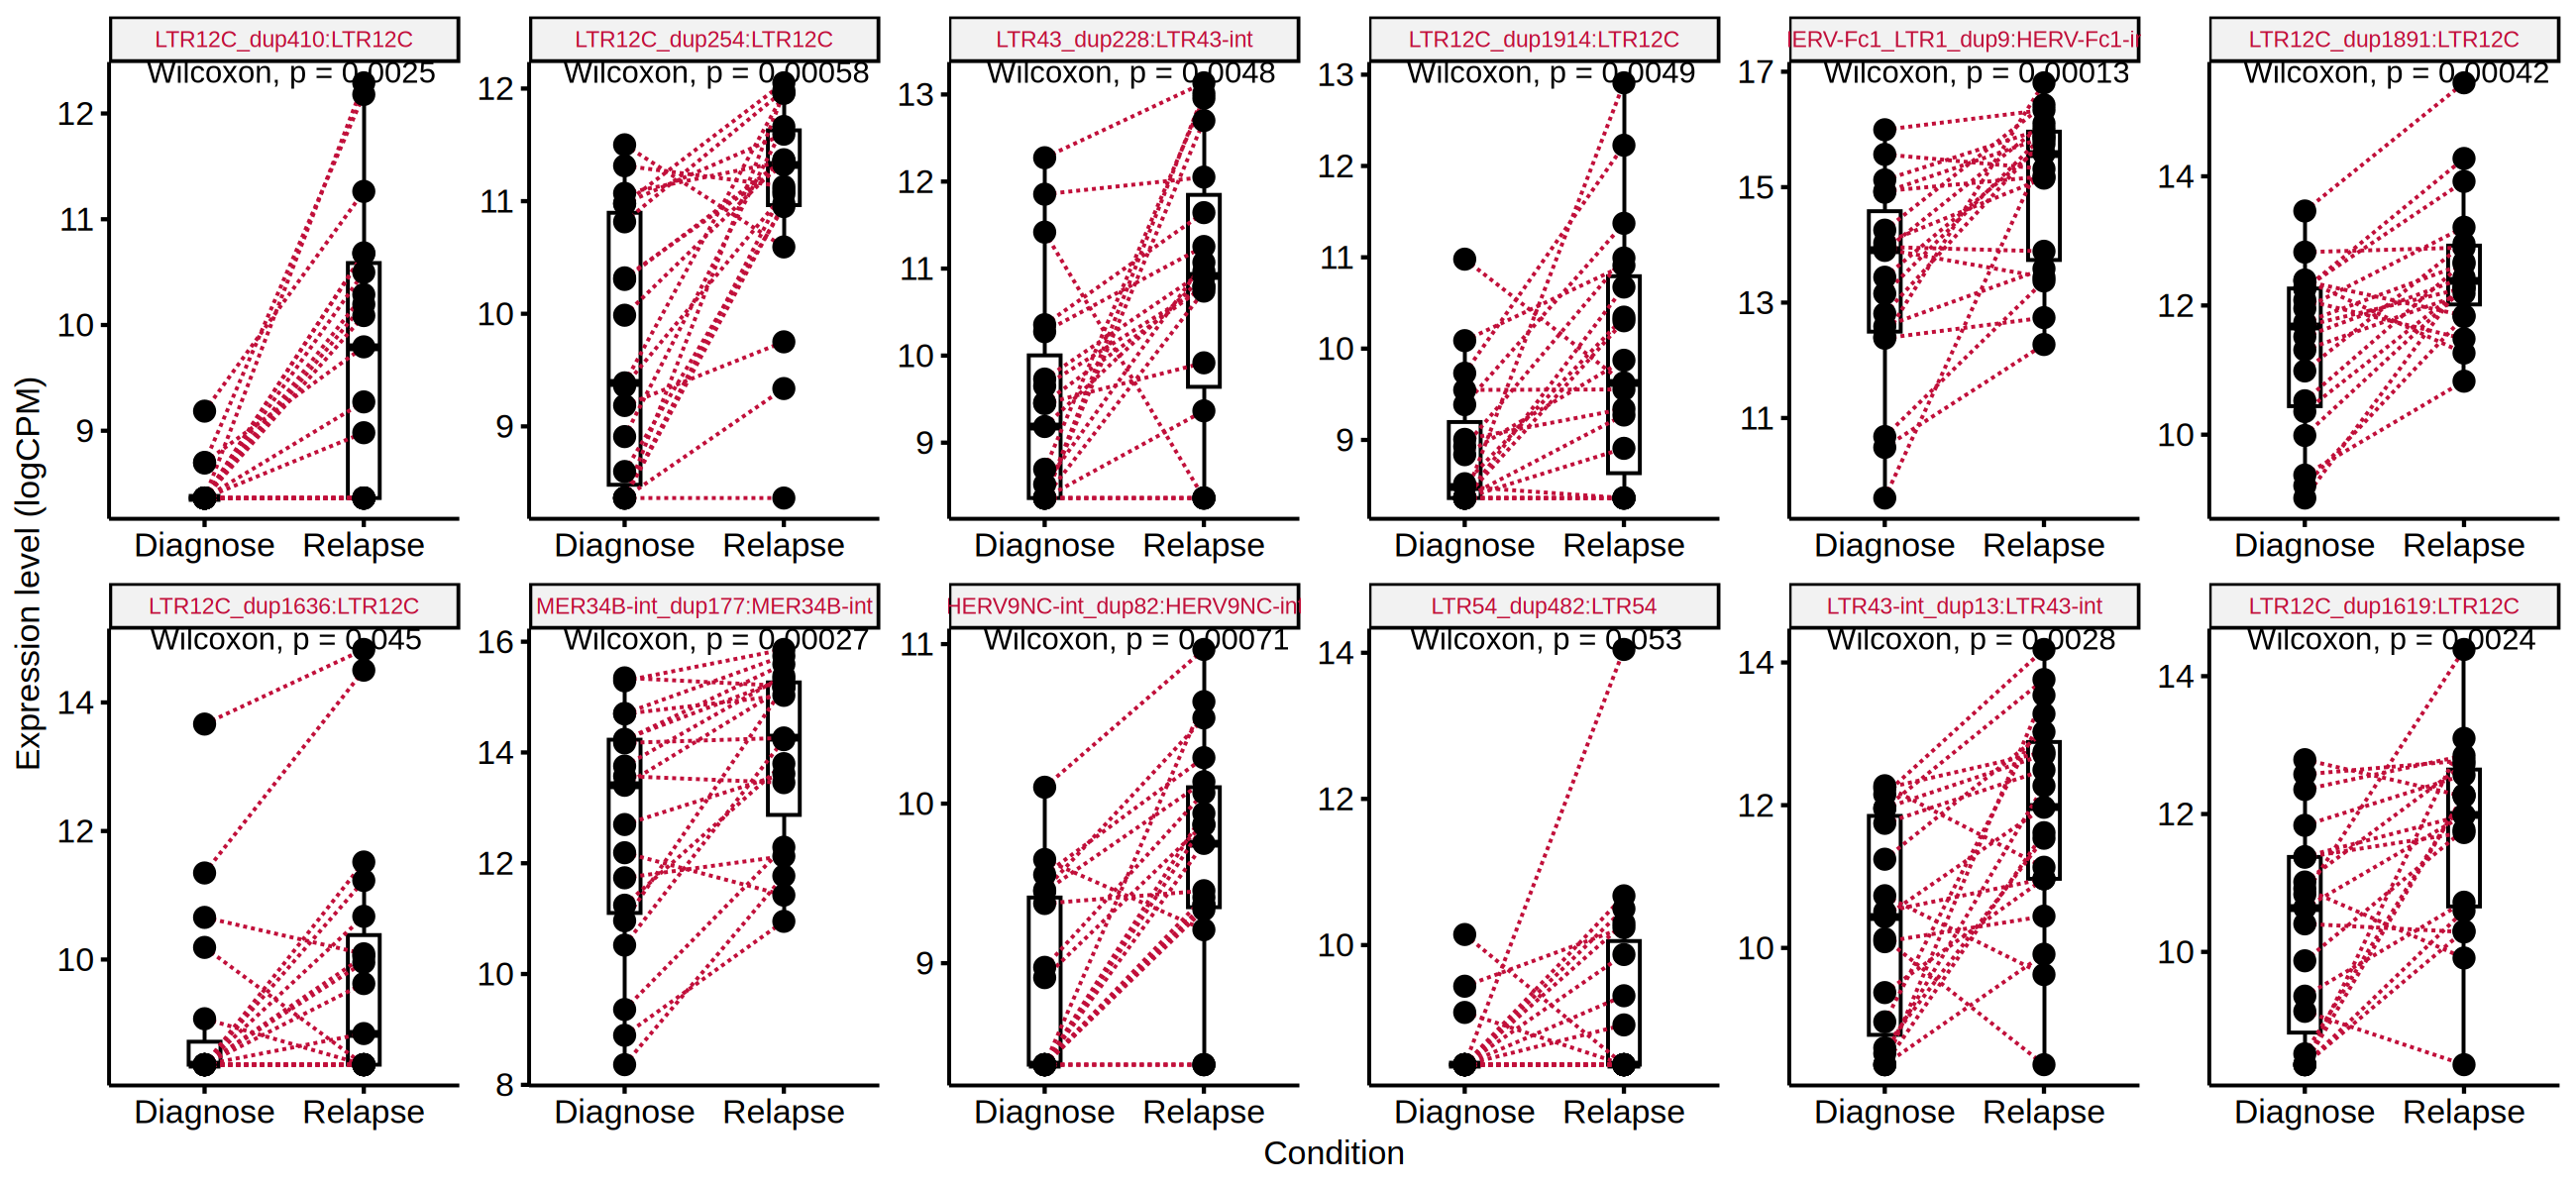

In [451]:
dsn_row = deg_relapse_local_te[FDR < 0.1 & logFC > 0, ][order(PValue), ][1:12, ]
dsn_row = dsn_row[order(class_id), ]
dsn[, group := factor(group, levels = c('Dx', 'rel')) ]
dsn_sorted = dsn[order(group), ]
plotdat = logcpm_replase_local_te[dsn_row$rn, dsn_sorted$sample_name]
rownames(plotdat) = dsn_row$id

plotdat = as.data.table(melt(plotdat))
plotdat[, group := sub('.*_', '', Var2) ]
plotdat[, patient := sub('(AML_\\d+)_.*', '\\1', Var2) ]
plotdat = dcast(plotdat, Var1 + patient ~ group, value.var = 'value')
setnames(plotdat, c('TE gene', 'patient', 'Diagnose', 'Relapse'))

options(repr.plot.width = 13, repr.plot.height = 6, repr.plot.res = 200)
ggpaired(plotdat, cond1 = 'Diagnose', cond2 = 'Relapse', width = .2, point.size = 3, line.color = '#C10F3A', linetype = 'dashed', palette = "npg" ) + 
stat_compare_means(paired = T) +
facet_wrap(~ `TE gene`, ncol = 6, scale = 'free') + ylab('Expression level (logCPM)') +
theme(strip.text = element_text(size = 8, color = "#C10F3A"))

In [440]:
telocal_sel = deg_relapse_local_te[FDR < 0.1, ]
telocal_sel = add_ann(telocal_sel)
telocal_sel

# export 

In [446]:
write.table(count_df_te, file = 'count_df_te.tsv', sep = '\t')
write.table(count_df_coding, file = 'count_df_coding.tsv', sep = '\t')
write.table(count_dt_sel2_df, file = 'count_dt_sel2_df.tsv', sep = '\t')

write.table(logcpm_replase_local_te, file = 'logcpm_replase_local_te.tsv', sep = '\t')
write.table(logcpm_replase_coding, file = 'logcpm_replase_coding.tsv', sep = '\t')
write.table(logcpm_replase_te, file = 'logcpm_replase_te.tsv', sep = '\t')

write.table(deg_relapse_coding, file = 'deg_relapse_coding.tsv', sep = '\t')
write.table(deg_relapse_te, file = 'deg_relapse_te.tsv', sep = '\t')
write.table(deg_relapse_local_te, file = 'deg_relapse_local_te.tsv', sep = '\t')

write.table(tecount_sel, file = 'tecount_relapse_sel.tsv', sep = '\t')
write.table(telocal_sel, file = 'telocal_relapse_sel.tsv', sep = '\t')

write.table(dsn, file = 'dsn.tsv')


In [456]:
write.table(dsn, file = 'dsn.tsv')


In [4]:
count_df_te = read.table(file = 'count_df_te.tsv', sep = '\t')
count_df_coding = read.table(file = 'count_df_coding.tsv', sep = '\t')
count_dt_sel2_df = read.table(file = 'count_dt_sel2_df.tsv', sep = '\t')

logcpm_replase_local_te = read.table(file = 'logcpm_replase_local_te.tsv', sep = '\t')
logcpm_replase_coding = read.table(file = 'logcpm_replase_coding.tsv', sep = '\t')
logcpm_replase_te = read.table(file = 'logcpm_replase_te.tsv', sep = '\t')

deg_relapse_coding = read.table(file = 'deg_relapse_coding.tsv', sep = '\t')
deg_relapse_te = read.table(file = 'deg_relapse_te.tsv', sep = '\t')
deg_relapse_local_te = read.table(file = 'deg_relapse_local_te.tsv', sep = '\t')

tecount_sel = read.table(file = 'tecount_relapse_sel.tsv', sep = '\t')
telocal_sel = read.table(file = 'teloca_relapse_sel.tsv', sep = '\t')


Warning message in file(file, "rt"):
"cannot open file 'teloca_relapse_sel.tsv': No such file or directory"


ERROR: Error in file(file, "rt"): cannot open the connection


In [5]:
dsn = fread('dsn.tsv')

Warning message in fread("dsn.tsv"):
"Detected 39 column names but the data has 40 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."
